In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33781")
client

<Client: 'tcp://127.0.0.1:33781' processes=8 threads=40, memory=157.39 GiB>

In [45]:
client.restart()

<Client: 'tcp://127.0.0.1:44895' processes=0 threads=0, memory=0 B>

In [2]:
import numpy as np
import xarray as xr
import gsw
import gcm_filters
from xmitgcm import open_mdsdataset
from xgcm.grid import Grid
from MITgcmutils import jmd95
from dask.diagnostics import ProgressBar
import os.path as op
from scipy.interpolate import griddata
import dask_image.ndfilters as dsfilt
import scipy.sparse as spar
import dask.array as dsar
from xhistogram.xarray import histogram as xhist
# import xscale
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.ticker as mtick
# import matplotlib
# matplotlib.rcParams['text.usetex'] = True
%matplotlib inline

In [3]:
rdir = '/tank/chaocean/'
ddir = '/tank/topog/tuchida/TWA/'
tdgs = '/tank/tdgs/tuchida/TWA'
spec = '/tank/spectre/tuchida/TWA'

In [4]:
year = 1967

grav = 9.81
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
Cp = 3.994e3
ySstart = -15
yNstart = 15
yend = 50
ts, bs = (13,48)
nremap = 50
nsig = 25

mchunk = 1
xchunk = 250
ychunk = 400
schunk = -1

In [5]:
ystart = ySstart
itime = 1421280
dsbathy = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                                 % (0,year)), 
                         grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
                         iters=itime,
                         prefix=['diag_ocnTave'], delta_t=2e2,
                        ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                              YG=slice(ystart-12**-1,yend+2*12**-1)
                             ).chunk({'XC':xchunk,'XG':xchunk,
                                 'YC':ychunk,'YG':ychunk})
ds = open_mdsdataset(op.join(rdir,'qjamet/RUNS/ORAR/memb%02d/run%4d/ocn/' 
                             % (0,year)), 
                     grid_dir=op.join(rdir,'grid_chaO/gridMIT_update1/'),
                     iters=itime,
                     prefix=['diag_ocnTave'], delta_t=2e2,
                    ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                          YG=slice(ystart-12**-1,yend+2*12**-1)
                         ).chunk({'XC':xchunk,'XG':xchunk,
                                  'YC':ychunk,'YG':ychunk})


nmembs = np.arange(36,60)

for memb in nmembs:
    if memb == 36:
        dsz = xr.open_zarr(op.join(spec,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                           % (year,memb,itime))
                                  ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                        YG=slice(ystart-12**-1,yend+2*12**-1)
                                       ).reset_coords(drop=True).isel(time=0)
        
    else:
        dsz = xr.concat([dsz, xr.open_zarr(op.join(spec,'5Dave/Zs/run%4d/memb%02d/%010d/' 
                                                   % (year,memb,itime))
                                          ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                                YG=slice(ystart-12**-1,yend+2*12**-1)
                                               ).reset_coords(drop=True).isel(time=0)
                        ], 'nmemb')

# dsmnp = xr.open_zarr(op.join(spec,'5Dave/run%4d/HorDynp_%2d-%2dmembs/%010d/' 
#                                     % (year,36,59,itime))
#                            ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
#                                  YG=slice(ystart-12**-1,yend+2*12**-1)
#                                 ).reset_coords(drop=True)
# dstp = xr.open_zarr(op.join(spec,'5Dave/run%4d/PTracerp/%010d/' 
#                             % (year,itime))
#                    ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
#                         ).reset_coords(drop=True)
dsFp = xr.open_zarr(op.join(spec,'5Dave/run%4d/EddyPTrFlx/%010d/'    # Explicit diagnosis of the eddy flux
                            % (year,itime))
                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                        ).reset_coords(drop=True)
# dsFp = xr.open_zarr(op.join(spec,'5Dave/run%4d/EddyPTrFlx_res/unweighted/%010d/' 
#                             % (year,itime))
#                    ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
#                         ).reset_coords(drop=True)

dsTp = xr.open_zarr(op.join(spec,'5Dave/run%4d/EddyTrFlx/explicit/%2d-%2dmembs/%010d/' 
                            % (year,36,59,itime))
                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                        ).reset_coords(drop=True)
# dsmnp = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/Dynp/memb%02d/%010d/' 
#                                      % (year,memb,itime))
#                             ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
#                                   YG=slice(ystart-12**-1,yend+2*12**-1)
#                                  ).reset_coords(drop=True).isel(time=0)
        
# delta = .5*(dsz.delta_outer[1:].data 
#             + dsz.delta_outer[:-1].data)
# dsz.coords['nmemb'] = ('nmemb',nmembs)
# dsz.coords['delta'] = ('delta',delta)
# dsmnp.coords['delta'] = ('delta',delta)
# dstp.coords['delta'] = ('delta',delta)

# dsep = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/E-P/%010d/' 
#                             % (year,itime))
#                    ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
#                          YG=slice(ystart-12**-1,yend+2*12**-1)
#                         ).reset_coords(drop=True)
# dsep.coords['delta'] = ('delta',delta)


# dsdep = xr.open_zarr(op.join(tdgs,'5Dave/run%4d/divE-P/%010d/' 
#                             % (year,itime))
#                    ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
#                         ).reset_coords(drop=True)
# dsdep.coords['delta'] = ('delta',delta)
dsFp

/tmp/ipykernel_24857/2097722911.py:27: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  dsz = xr.open_zarr(op.join(spec,'5Dave/Zs/run%4d/memb%02d/%010d/'
/tmp/ipykernel_24857/2097722911.py:34: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidate

<xarray.Dataset>
Dimensions:      (XC: 1000, YC: 783, delta_outer: 55)
Coordinates:
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 -15.08 -15.0 -14.92 -14.83 ... 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Data variables:
    upP0phat     (YC, XC, delta_outer) float32 dask.array<chunksize=(100, 100, 55), meta=np.ndarray>
    upP1phat     (YC, XC, delta_outer) float32 dask.array<chunksize=(100, 100, 55), meta=np.ndarray>
    upP2phat     (YC, XC, delta_outer) float32 dask.array<chunksize=(100, 100, 55), meta=np.ndarray>
    upP3phat     (YC, XC, delta_outer) float32 dask.array<chunksize=(100, 100, 55), meta=np.ndarray>
    vpP0phat     (YC, XC, delta_outer) float32 dask.array<chunksize=(100, 100, 55), meta=np.ndarray>
    vpP1phat     (YC, XC, delta_outer) float32 dask.array<chunksize=(100, 100, 55), meta=np.ndarray>
    vpP2phat     (YC, XC, delta_outer) float32 dask.array<chunksize=(100, 100, 55), meta=np.ndarray>
    vpP3phat     (YC, XC, delta_outer) float32 dask.array<chunksize=(100, 100, 55), meta=np.ndarray>

In [6]:
dsmnb = xr.open_zarr(op.join(spec,'5Dave/run%4d/HorDynb_%2d-%2dmembs/%010d/' 
                            % (year,36,59,itime))
                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                         YG=slice(ystart-12**-1,yend+2*12**-1)
                        ).reset_coords(drop=True)
dsmnb.coords['delta'] = dsz.delta

dsptb = xr.open_zarr(op.join(spec,'5Dave/run%4d/PTracerb/%010d/' 
                            % (year,itime))
                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                        ).reset_coords(drop=True)
dsptb.coords['delta'] = dsz.delta

dstb = xr.open_zarr(op.join(spec,'5Dave/run%4d/Tracerb/%2d-%2dmembs/%010d/' 
                            % (year,36,59,itime))
                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1)
                        ).reset_coords(drop=True)
dstb.coords['delta'] = dsz.delta

dszb = xr.open_zarr(op.join(spec,'5Dave/run%4d/Zetab_%2d-%2dmembs/%010d/' 
                            % (year,36,59,itime))
                   ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                         YG=slice(ystart-12**-1,yend+2*12**-1)
                        ).reset_coords(drop=True)
dszb.coords['delta'] = dsz.delta
dstb

<xarray.Dataset>
Dimensions:      (XC: 1000, YC: 783, delta_outer: 55, delta: 54)
Coordinates:
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 -15.08 -15.0 -14.92 -14.83 ... 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
    time         timedelta64[ns] 3290 days
  * delta        (delta) float64 20.17 20.52 20.87 21.21 ... 29.13 29.16 29.19
Data variables:
    shat         (YC, XC, delta_outer) float32 dask.array<chunksize=(100, 100, 55), meta=np.ndarray>
    that         (YC, XC, delta_outer) float32 dask.array<chunksize=(100, 100, 55), meta=np.ndarray>

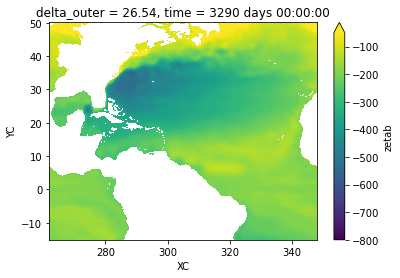

In [7]:
dszb.zetab.isel(delta_outer=23).plot(vmin=-8e2, vmax=-50)

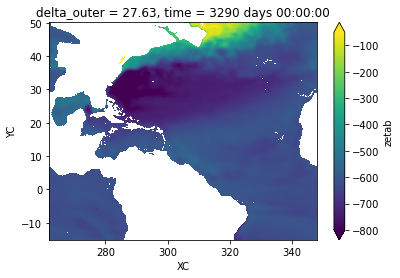

In [71]:
dszb.zetab.isel(delta_outer=30).plot(vmin=-8e2, vmax=-50)

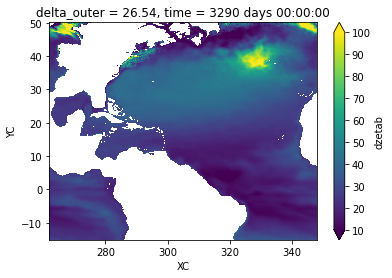

In [147]:
dszb.dzetab.isel(delta_outer=23).plot(vmin=1e1, vmax=1e2)

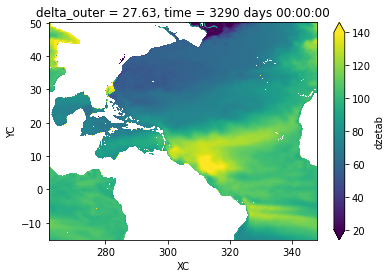

In [145]:
dszb.dzetab.isel(delta_outer=30).plot(vmin=2e1, vmax=1.4e2)

In [7]:
grid = Grid(dsz, periodic=['X'], 
            coords={'Z':{'center':'delta','outer':'delta_outer'},
                    'Y':{'center':'YC','left':'YG'},
                    'X':{'center':'XC','left':'XG'}}
           )
grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   delta --> outer
  * outer    delta_outer --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center

In [8]:
fC = xr.apply_ufunc(gsw.f, dsz.YC, dask='parallelized', output_dtypes=['float',])
fG = xr.apply_ufunc(gsw.f, dsz.YG, dask='parallelized', output_dtypes=['float',])
buoyb = -grav * dsz.delta * rhoConst**-1
buoybp1 = -grav * dsz.delta_outer * rhoConst**-1
dzetaF = dsz.dzetaF.where(dsz.dzetaF!=0.)
dzetaFy = dsz.dzetaFy.where(dsz.dzetaFy!=0.)
dzetaFx = dsz.dzetaFx.where(dsz.dzetaFx!=0.)
sigma = dzetaF * -grid.diff(buoyb,'Z',boundary='fill')**-1
sigmay = dzetaFy * xr.DataArray(-grid.diff(buoyb,'Z',boundary='fill').data**-1,
                                dims='deltay_outer', coords={'deltay_outer':dsz.deltay_outer}
                               )
sigmax = dzetaFx * xr.DataArray(-grid.diff(buoyb,'Z',boundary='fill').data**-1,
                                dims='deltax_outer', coords={'deltax_outer':dsz.deltax_outer}
                               )

zetab = dszb.zetab
zetaxb = dszb.zetaxb
zetayb = dszb.zetayb

sigmab = (dszb.dzetab
          * -grid.diff(buoyb,'Z',boundary='fill')**-1
         ).compute()
sigmaxb = (dszb.dzetaxb 
           * -grid.diff(buoyb,'Z',boundary='fill')**-1
          )
sigmayb = (dszb.dzetayb  
           * -grid.diff(buoyb,'Z',boundary='fill')**-1
          )

vhat = dsmnb.vhat
uhat = dsmnb.uhat

In [11]:
# varpihat = dsmnb.varpihat

vpp = dsmnp.vpp
upp = xr.DataArray(dsmnp.upp.data, dims=['nmemb','YC','XG','delta_outer'],
                   coords={'nmemb':nmembs,'YC':ds.YC,'XG':ds.XG,'delta_outer':dsz.delta_outer}
                  )
# varpipp = dsmnp.varpipp
vpp

NameError: name 'dsmnp' is not defined

In [12]:
e00 = dsep.e00
e10 = dsep.e10
e20 = dsep.e20_0 + dsep.e20_1
e01 = dsep.e01
e11 = dsep.e11
e21 = dsep.e21_0 + dsep.e21_1

e00_x = dsdep.e00x
e10_y = dsdep.e10y
e20_b = dsdep.e20_0b + dsdep.e20_1b
e01_x = dsdep.e01x
e11_y = dsdep.e11y
e21_b = dsdep.e21_0b + dsdep.e21_1b

Eu = e00_x + e10_y + e20_b
Ev = e01_x + e11_y + e21_b
PVpx = sigmab**-1 * Ev
PVpy = -sigmab**-1 * Eu

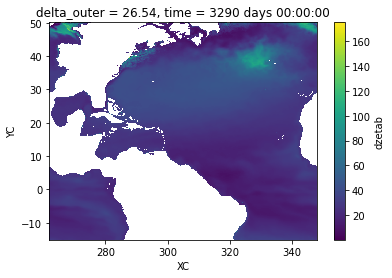

In [140]:
dszb.dzetab.where(dszb.dzetab!=0.).where(dszb.zetab!=0.).isel(delta_outer=23).plot()

In [9]:
mask = ~dszb.dzetab.where(dszb.dzetab!=0.).where(dszb.zetab!=0.
                                              ).where(dstb.that!=0.
                                                     ).where(dstb.shat!=0.
                                                            ).where(dsptb.P0hat!=0
                                                                   ).where(dsptb.P1hat!=0
                                                                          ).where(dsptb.P2hat!=0
                                                                                 ).where(dsptb.P3hat!=0
                                                                                        ).where(dsTp.upTphat!=0.
                                                                                               ).where(dsTp.upSphat!=0.
                                                                                                      ).where(dsTp.vpTphat!=0.
                                                                                                             ).where(dsTp.vpSphat!=0.
                                                                                                                    ).to_masked_array().mask
maskx = ~dszb.dzetaxb.where(dszb.dzetaxb!=0.).where(dszb.zetaxb!=0.).to_masked_array().mask
masky = ~dszb.dzetayb.where(dszb.dzetayb!=0.).where(dszb.zetayb!=0.).to_masked_array().mask

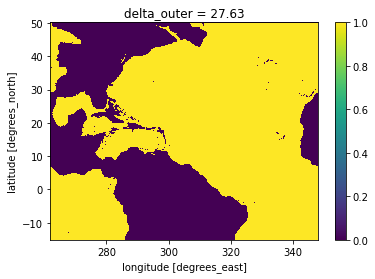

In [10]:
wet_mask = xr.DataArray(np.zeros((len(dsz.YC),len(dsz.XC),len(dsz.delta_outer))),
                        dims=['YC','XC','delta_outer'],
                        coords={'YC':dsz.YC,'XC':dsz.XC,
                                'delta_outer':dsz.delta_outer}
)
wet_mask[1:-1] = mask[1:-1].astype(np.float64)
wet_mask = wet_mask.chunk({'delta_outer':10})
wet_mask.isel(delta_outer=30).plot()

In [11]:
area = (grid.interp(ds.dxG,'Y',boundary='extend') 
        * grid.interp(ds.dyG,'X',boundary='extend')
       )
area

<xarray.DataArray (YC: 783, XC: 1000)>
dask.array<mul, shape=(783, 1000), dtype=float32, chunksize=(400, 250), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) float32 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08

In [12]:
dxw = xr.DataArray(ds.dxC.data,
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(ds.dyG.data,
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(ds.dxG.data,
                   dims=area.dims, coords=area.coords
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(ds.dyC.data,
                   dims=area.dims, coords=area.coords
                  ) # y-spacing centered at southern cell edge
dxw

<xarray.DataArray 'rechunk-merge-a8c57dcb04e49eaa270de1449d0fc2cb' (YC: 783,
                                                                    XC: 1000)>
dask.array<rechunk-merge, shape=(783, 1000), dtype=>f4, chunksize=(400, 250), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) float32 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08

In [13]:
dx_min = min(dxw.min(), dyw.min(), dxs.min(), dys.min())
dx_min = dx_min.values
dx_min

array(6134.034, dtype=float32)

In [14]:
kappa_w = xr.ones_like(wet_mask)
kappa_s = xr.ones_like(wet_mask)
kappa_s

<xarray.DataArray (YC: 783, XC: 1000, delta_outer: 55)>
dask.array<full_like, shape=(783, 1000, 55), dtype=float64, chunksize=(783, 1000, 10), chunktype=numpy.ndarray>
Coordinates:
  * YC           (YC) float32 -15.08 -15.0 -14.92 -14.83 ... 49.92 50.0 50.08
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2

In [15]:
vort = (grid.diff(xr.DataArray(vhat.data, dims=['YG','XC','delta_outer'],
                               coords={'YG':ds.YG,'XC':ds.XC,'delta_outer':dsz.delta_outer}
                              )*ds.dyC,'X') 
        - grid.diff(xr.DataArray(uhat.data, dims=['YC','XG','delta_outer'],
                                 coords={'YC':ds.YC,'XG':ds.XG,'delta_outer':dsz.delta_outer}
                                )*ds.dxC,'Y',boundary='fill')
       ) * ds.rAz**-1
Pi = ((grid.interp(grid.interp(vort,'X'),'Y',boundary='fill') 
       + fC) * sigmab**-1)

vort_x = grid.diff(vort,'X') * ds.dxG**-1
vort_y = grid.diff(vort,'Y',boundary='fill') * ds.dyG**-1

zetab_x = grid.diff(xr.DataArray(zetaxb.data, dims=['YC','XG','delta_outer'],
                                 coords={'YC':dsz.YC,'XG':dsz.XG,'delta_outer':dsz.delta_outer}
                                ),'X')*grid.interp(ds.dxC.sel(YC=slice(ySstart-12**-1,yend+2*12**-1)),
                                                   'X')**-1
zetab_y = grid.diff(xr.DataArray(zetayb.data, dims=['YG','XC','delta_outer'],
                                 coords={'YG':dsz.YG,'XC':dsz.XC,'delta_outer':dsz.delta_outer}
                                ),'Y',boundary='fill')*grid.interp(ds.dyC.sel(YG=slice(ySstart-12**-1,
                                                                                       yend+2*12**-1)),
                                                                   'Y',boundary='fill')**-1

sigmab_x = grid.interp(grid.diff(zetab_x,'Z',boundary='fill') 
                       * grid.diff(buoybp1,'Z',boundary='fill')**-1,
                       'Z',boundary='fill'
                      ).compute()
sigmab_y = grid.interp(grid.diff(zetab_y,'Z',boundary='fill') 
                       * grid.diff(buoybp1,'Z',boundary='fill')**-1,
                       'Z',boundary='fill'
                      ).compute()
sigmab_x

<xarray.DataArray (YC: 783, XC: 1000, delta_outer: 55)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 -15.08 -15.0 -14.92 -14.83 ... 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2

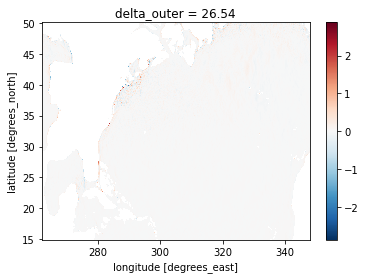

In [31]:
sigmab_x.isel(delta_outer=23).plot()

In [16]:
filter_scale = 50e3    # 50km
filt_mask = wet_mask.chunk({'YC':-1,'XC':-1}).reset_coords(drop=True)

gauss_filter = gcm_filters.Filter(
        filter_scale=filter_scale,
        dx_min=dx_min,
    #     n_steps=36,
        filter_shape=gcm_filters.FilterShape.GAUSSIAN,
        grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
        grid_vars={
            'wet_mask': filt_mask, 
            'dxw': dxw.chunk({'YC':-1,'XC':-1}), 'dyw': dyw.chunk({'YC':-1,'XC':-1}), 
            'dxs': dxs.chunk({'YC':-1,'XC':-1}), 'dys': dys.chunk({'YC':-1,'XC':-1}), 
            'area': area.chunk({'YC':-1,'XC':-1}), 
            'kappa_w': kappa_w.chunk({'YC':-1,'XC':-1}), 
            'kappa_s': kappa_s.chunk({'YC':-1,'XC':-1})
        }
    )
gauss_filter

Filter(filter_scale=50000.0, dx_min=array(6134.034, dtype=float32), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=9, n_iterations=1, grid_type=<GridType.IRREGULAR_WITH_LAND: 5>)

In [17]:
# Pi_sm = hann_filt(Pi.chunk({'YC':ychunk,'XC':xchunk}), nker=nk, cutoff=cf)
P0b_sm = gauss_filter.apply(dsptb.P0hat.where(wet_mask!=0.).chunk({'YC':-1,'XC':-1}), dims=['YC','XC']
                           )
P1b_sm = gauss_filter.apply(dsptb.P1hat.where(wet_mask!=0.).chunk({'YC':-1,'XC':-1}), dims=['YC','XC']
                           )
P2b_sm = gauss_filter.apply(dsptb.P2hat.where(wet_mask!=0.).chunk({'YC':-1,'XC':-1}), dims=['YC','XC']
                           )
P3b_sm = gauss_filter.apply(dsptb.P3hat.where(wet_mask!=0.).chunk({'YC':-1,'XC':-1}), dims=['YC','XC']
                           )

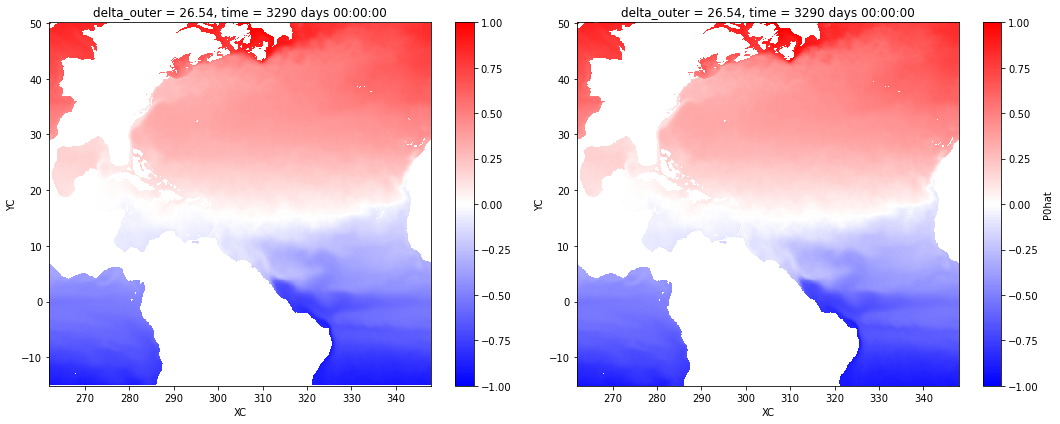

In [133]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

P0b_sm.isel(delta_outer=23).plot(ax=ax1, vmax=1, cmap='bwr', rasterized=True)
dsptb.P0hat.isel(delta_outer=23).plot(ax=ax2, vmax=1, cmap='bwr', rasterized=True)

In [18]:
# absvort = fC + grid.interp(grid.interp(vort,'X'),'Y',boundary='fill')
# Pi_xs = (grid.interp(vort_x,'Y',boundary='fill')
#          - sigmab_x * sigmab**-1 * absvort
#         )
# Pi_ys = (grid.diff(fG,'Y',boundary='fill') 
#          * grid.interp(ds.dyG.sel(YC=slice(ySstart-12**-1,
#                                            yend+2*12**-1)),'X')**-1 
#          + grid.interp(vort_y,'X')
#         ) - sigmab_y * sigmab**-1 * absvort

P0bsm_x = (grid.diff(grid.interp(P0b_sm,'X').where(xr.DataArray(maskx, dims=['YC','XG','delta_outer'])!=0.),'X') 
           * grid.interp(ds.dxG,'Y',boundary='extend')**-1)
P0bsm_y = (grid.diff(grid.interp(P0b_sm,'Y',boundary='extend').where(xr.DataArray(masky, dims=['YG','XC','delta_outer'])!=0.),
                     'Y',boundary='extend') 
           * grid.interp(ds.dyG,'X')**-1)
P1bsm_x = (grid.diff(grid.interp(P1b_sm,'X').where(xr.DataArray(maskx, dims=['YC','XG','delta_outer'])!=0.),'X') 
           * grid.interp(ds.dxG,'Y',boundary='extend')**-1)
P1bsm_y = (grid.diff(grid.interp(P1b_sm,'Y',boundary='extend').where(xr.DataArray(masky, dims=['YG','XC','delta_outer'])!=0.),
                     'Y',boundary='extend') 
           * grid.interp(ds.dyG,'X')**-1)
P2bsm_x = (grid.diff(grid.interp(P2b_sm,'X').where(xr.DataArray(maskx, dims=['YC','XG','delta_outer'])!=0.),'X') 
           * grid.interp(ds.dxG,'Y',boundary='extend')**-1)
P2bsm_y = (grid.diff(grid.interp(P2b_sm,'Y',boundary='extend').where(xr.DataArray(masky, dims=['YG','XC','delta_outer'])!=0.),
                     'Y',boundary='extend') 
           * grid.interp(ds.dyG,'X')**-1)
P3bsm_x = (grid.diff(grid.interp(P3b_sm,'X').where(xr.DataArray(maskx, dims=['YC','XG','delta_outer'])!=0.),'X') 
           * grid.interp(ds.dxG,'Y',boundary='extend')**-1)
P3bsm_y = (grid.diff(grid.interp(P3b_sm,'Y',boundary='extend').where(xr.DataArray(masky, dims=['YG','XC','delta_outer'])!=0.),
                     'Y',boundary='extend') 
           * grid.interp(ds.dyG,'X')**-1)
# Pi_x = Pi_xs * sigmab**-1
# Pi_y = Pi_ys * sigmab**-1
P0b_x = (grid.diff(grid.interp(dsptb.P0hat.where(wet_mask!=0.),'X').where(xr.DataArray(maskx, dims=['YC','XG','delta_outer'])!=0.),'X') 
         * grid.interp(ds.dxG,'Y',boundary='extend')**-1)
P0b_y = (grid.diff(grid.interp(dsptb.P0hat.where(wet_mask!=0.),
                               'Y',boundary='extend').where(xr.DataArray(masky, dims=['YG','XC','delta_outer'])!=0.),
                   'Y',boundary='extend') 
         * grid.interp(ds.dyG,'X')**-1)
P1b_x = (grid.diff(grid.interp(dsptb.P1hat.where(wet_mask!=0.),'X').where(xr.DataArray(maskx, dims=['YC','XG','delta_outer'])!=0.),'X') 
         * grid.interp(ds.dxG,'Y',boundary='extend')**-1)
P1b_y = (grid.diff(grid.interp(dsptb.P1hat.where(wet_mask!=0.),
                               'Y',boundary='extend').where(xr.DataArray(masky, dims=['YG','XC','delta_outer'])!=0.),
                   'Y',boundary='extend') 
         * grid.interp(ds.dyG,'X')**-1)
P2b_x = (grid.diff(grid.interp(dsptb.P2hat.where(wet_mask!=0.),'X').where(xr.DataArray(maskx, dims=['YC','XG','delta_outer'])!=0.),'X') 
         * grid.interp(ds.dxG,'Y',boundary='extend')**-1)
P2b_y = (grid.diff(grid.interp(dsptb.P2hat.where(wet_mask!=0.),
                               'Y',boundary='extend').where(xr.DataArray(masky, dims=['YG','XC','delta_outer'])!=0.),
                   'Y',boundary='extend') 
         * grid.interp(ds.dyG,'X')**-1)
P3b_x = (grid.diff(grid.interp(dsptb.P3hat.where(wet_mask!=0.),'X').where(xr.DataArray(maskx, dims=['YC','XG','delta_outer'])!=0.),'X') 
         * grid.interp(ds.dxG,'Y',boundary='extend')**-1)
P3b_y = (grid.diff(grid.interp(dsptb.P3hat.where(wet_mask!=0.),
                               'Y',boundary='extend').where(xr.DataArray(masky, dims=['YG','XC','delta_outer'])!=0.),
                   'Y',boundary='extend') 
         * grid.interp(ds.dyG,'X')**-1)

print(P0b_y, P0b_x)

<xarray.DataArray (YC: 783, XC: 1000, delta_outer: 55)>
dask.array<mul, shape=(783, 1000, 55), dtype=float32, chunksize=(100, 100, 10), chunktype=numpy.ndarray>
Coordinates:
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 -15.08 -15.0 -14.92 -14.83 ... 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2 <xarray.DataArray (YC: 783, XC: 1000, delta_outer: 55)>
dask.array<mul, shape=(783, 1000, 55), dtype=float32, chunksize=(100, 100, 10), chunktype=numpy.ndarray>
Coordinates:
  * XC           (XC) float32 262.0 262.1 262.2 262.3 ... 347.8 347.9 348.0
  * YC           (YC) float32 -15.08 -15.0 -14.92 -14.83 ... 49.92 50.0 50.08
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2


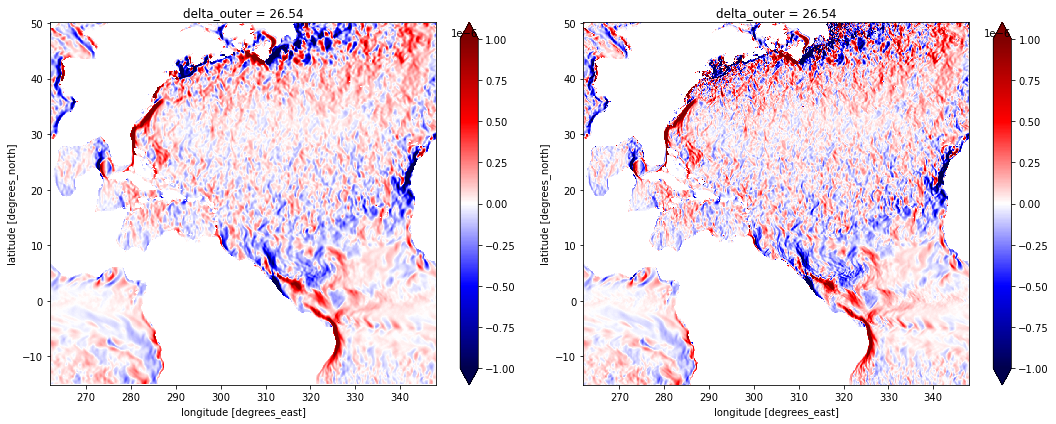

In [136]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

P0bsm_x.isel(delta_outer=23).plot(ax=ax1, vmax=1e-6, cmap='seismic', rasterized=True)
P0b_x.isel(delta_outer=23).plot(ax=ax2, vmax=1e-6, cmap='seismic', rasterized=True)

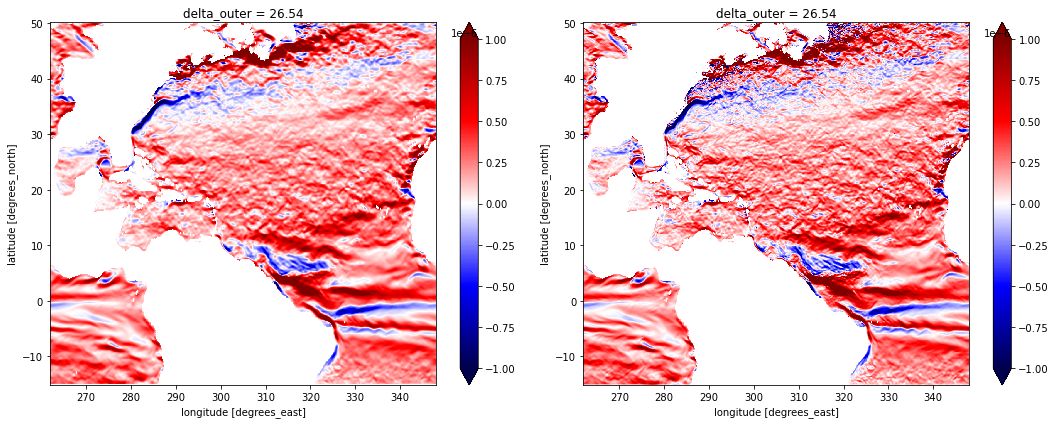

In [137]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

P0bsm_y.isel(delta_outer=23).plot(ax=ax1, vmax=1e-6, cmap='seismic', rasterized=True)
P0b_y.isel(delta_outer=23).plot(ax=ax2, vmax=1e-6, cmap='seismic', rasterized=True)

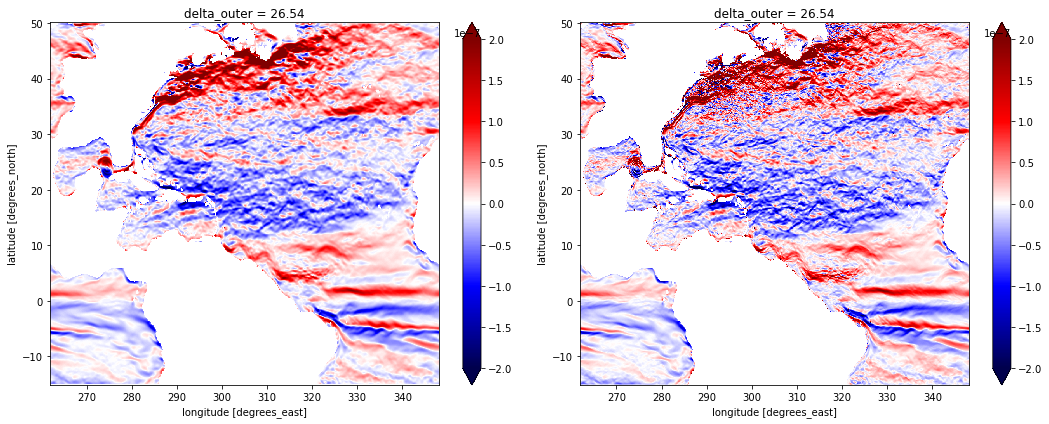

In [138]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

P2bsm_y.isel(delta_outer=23).plot(ax=ax1, vmax=2e-7, cmap='seismic', rasterized=True)
P2b_y.isel(delta_outer=23).plot(ax=ax2, vmax=2e-7, cmap='seismic', rasterized=True)

In [19]:
# that_sm = hann_filt(dstb.that.where(wet_mask!=0.), nker=nk, cutoff=cf)
# shat_sm = hann_filt(dstb.shat.where(wet_mask!=0.), nker=nk, cutoff=cf)
that_sm = gauss_filter.apply(dstb.that.where(wet_mask!=0.).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
shat_sm = gauss_filter.apply(dstb.shat.where(wet_mask!=0.).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])

thatsm_x = (grid.diff(grid.interp(that_sm,'X').where(xr.DataArray(maskx, dims=['YC','XG','delta_outer'])!=0.),'X') 
            * grid.interp(ds.dxG,'Y',boundary='extend')**-1)
thatsm_y = (grid.diff(grid.interp(that_sm,'Y',boundary='extend').where(xr.DataArray(masky, dims=['YG','XC','delta_outer'])!=0.),
                      'Y',boundary='extend') 
            * grid.interp(ds.dyG,'X',boundary='extend')**-1)
shatsm_x = (grid.diff(grid.interp(shat_sm,'X').where(xr.DataArray(maskx, dims=['YC','XG','delta_outer'])!=0.),'X') 
            * grid.interp(ds.dxG,'Y',boundary='extend')**-1)
shatsm_y = (grid.diff(grid.interp(shat_sm,'Y',boundary='extend').where(xr.DataArray(masky, dims=['YG','XC','delta_outer'])!=0.),
                      'Y',boundary='extend') 
            * grid.interp(ds.dyG,'X',boundary='extend')**-1)
that_x = (grid.diff(grid.interp(dstb.that,'X').where(xr.DataArray(maskx, dims=['YC','XG','delta_outer'])!=0.),'X') 
          * grid.interp(ds.dxG,'Y',boundary='extend')**-1)
that_y = (grid.diff(grid.interp(dstb.that,'Y',boundary='extend').where(xr.DataArray(masky, dims=['YG','XC','delta_outer'])!=0.),
                    'Y',boundary='extend') 
          * grid.interp(ds.dyG,'X')**-1)
shat_x = (grid.diff(grid.interp(dstb.shat,'X').where(xr.DataArray(maskx, dims=['YC','XG','delta_outer'])!=0.),'X') 
          * grid.interp(ds.dxG,'Y',boundary='extend')**-1)
shat_y = (grid.diff(grid.interp(dstb.shat,'Y',boundary='extend').where(xr.DataArray(masky, dims=['YG','XC','delta_outer'])!=0.),
                    'Y',boundary='extend') 
          * grid.interp(ds.dyG,'X')**-1)

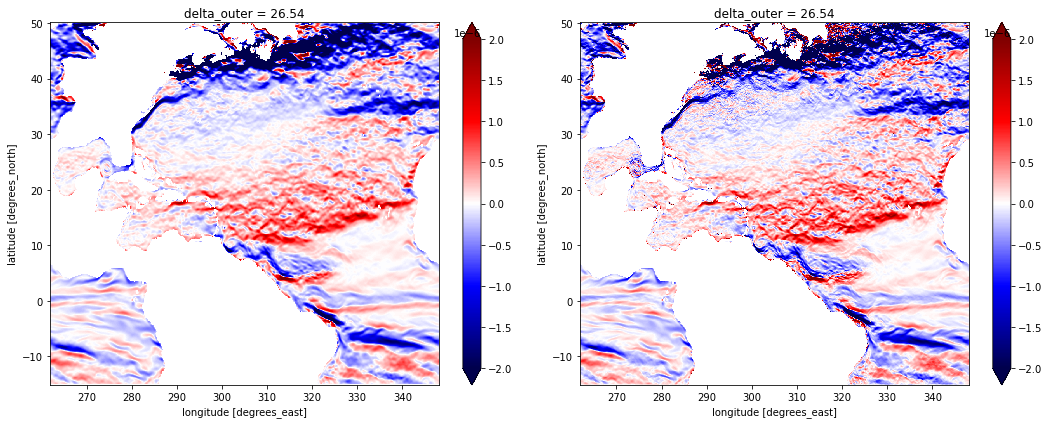

In [21]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

shatsm_y.isel(delta_outer=23).plot(ax=ax1, vmax=2e-6, cmap='seismic', rasterized=True)
shat_y.isel(delta_outer=23).plot(ax=ax2, vmax=2e-6, cmap='seismic', rasterized=True)

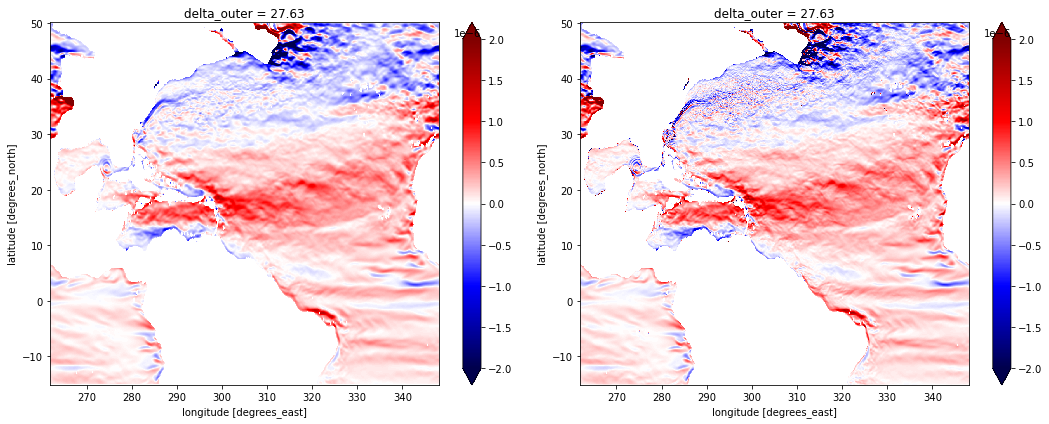

In [22]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

shatsm_y.isel(delta_outer=30).plot(ax=ax1, vmax=2e-6, cmap='seismic', rasterized=True)
shat_y.isel(delta_outer=30).plot(ax=ax2, vmax=2e-6, cmap='seismic', rasterized=True)

In [19]:
# uptphat_sm = hann_filt(upptpphat.chunk({'YC':ychunk,'XG':xchunk}), 
#                        dim=['YC','XG'], nker=nk, cutoff=cf)
# vptphat_sm = hann_filt(vpptpphat.chunk({'YG':ychunk,'XC':xchunk}), 
#                        dim=['YG','XC'], nker=nk, cutoff=cf)
# upsphat_sm = hann_filt(uppspphat.chunk({'YC':ychunk,'XG':xchunk}), 
#                        dim=['YC','XG'], nker=nk, cutoff=cf)
# vpsphat_sm = hann_filt(vppspphat.chunk({'YG':ychunk,'XC':xchunk}), 
#                        dim=['YG','XC'], nker=nk, cutoff=cf)
# PVpx_sm = hann_filt(PVpx, dim=['YC','XC'], nker=nk, cutoff=cf)
# PVpy_sm = hann_filt(PVpy, dim=['YC','XC'], nker=nk, cutoff=cf)

In [20]:
upP0hat_sm = gauss_filter.apply((dsFp.upP0phat.where(wet_mask!=0.)
                                 # /grid.interp(ds.dyG,'X')
                                ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
vpP0hat_sm = gauss_filter.apply((dsFp.vpP0phat.where(wet_mask!=0.)
                                 # /grid.interp(ds.dxG,'Y',boundary='extend')
                                ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
upP1hat_sm = gauss_filter.apply((dsFp.upP1phat.where(wet_mask!=0.)
                                 # /grid.interp(ds.dyG,'X')
                                ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
vpP1hat_sm = gauss_filter.apply((dsFp.vpP1phat.where(wet_mask!=0.)
                                 # /grid.interp(ds.dxG,'Y',boundary='extend')
                                ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
upP2hat_sm = gauss_filter.apply((dsFp.upP2phat.where(wet_mask!=0.)
                                 # /grid.interp(ds.dyG,'X')
                                ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
vpP2hat_sm = gauss_filter.apply((dsFp.vpP2phat.where(wet_mask!=0.)
                                 # /grid.interp(ds.dxG,'Y',boundary='extend')
                                ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
upP3hat_sm = gauss_filter.apply((dsFp.upP3phat.where(wet_mask!=0.)
                                 # /grid.interp(ds.dyG,'X')
                                ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
vpP3hat_sm = gauss_filter.apply((dsFp.vpP3phat.where(wet_mask!=0.)
                                 # /grid.interp(ds.dxG,'Y',boundary='extend')
                                ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])

upP0hat_raw = (dsFp.upP0phat.where(wet_mask!=0.)
               # /grid.interp(ds.dyG,'X')
              )
vpP0hat_raw = (dsFp.vpP0phat.where(wet_mask!=0.)
               # /grid.interp(ds.dxG,'Y',boundary='extend')
              )
upP1hat_raw = (dsFp.upP1phat.where(wet_mask!=0.)
               # /grid.interp(ds.dyG,'X')
              )
vpP1hat_raw = (dsFp.vpP1phat.where(wet_mask!=0.)
               # /grid.interp(ds.dxG,'Y',boundary='extend')
              )
upP2hat_raw = (dsFp.upP2phat.where(wet_mask!=0.)
               # /grid.interp(ds.dyG,'X')
              )
vpP2hat_raw = (dsFp.vpP2phat.where(wet_mask!=0.)
               # /grid.interp(ds.dxG,'Y',boundary='extend')
              )
upP3hat_raw = (dsFp.upP3phat.where(wet_mask!=0.)
               # /grid.interp(ds.dyG,'X')
              )
vpP3hat_raw = (dsFp.vpP3phat.where(wet_mask!=0.)
               # /grid.interp(ds.dxG,'Y',boundary='extend')
              )

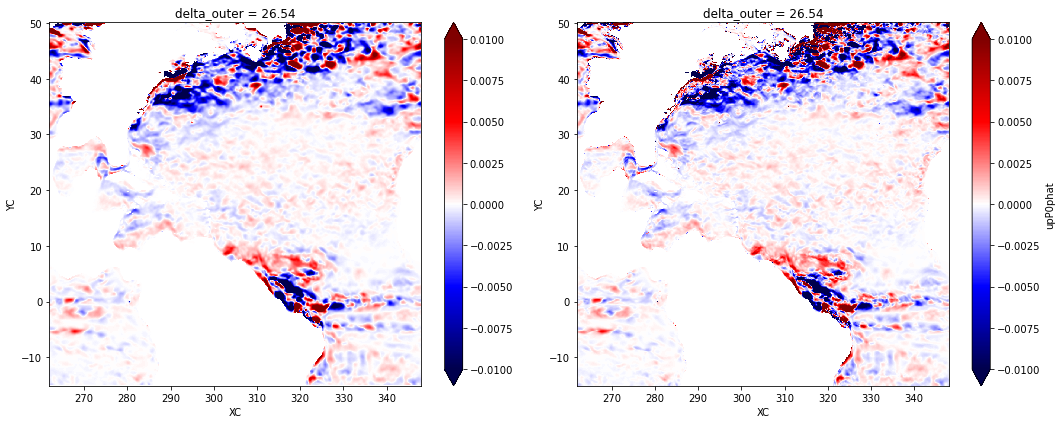

In [22]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

(upP0hat_sm).isel(delta_outer=23).plot(ax=ax1, vmax=1e-2, cmap='seismic', rasterized=True)
(dsFp.upP0phat).isel(delta_outer=23).plot(ax=ax2, vmax=1e-2, cmap='seismic', rasterized=True)

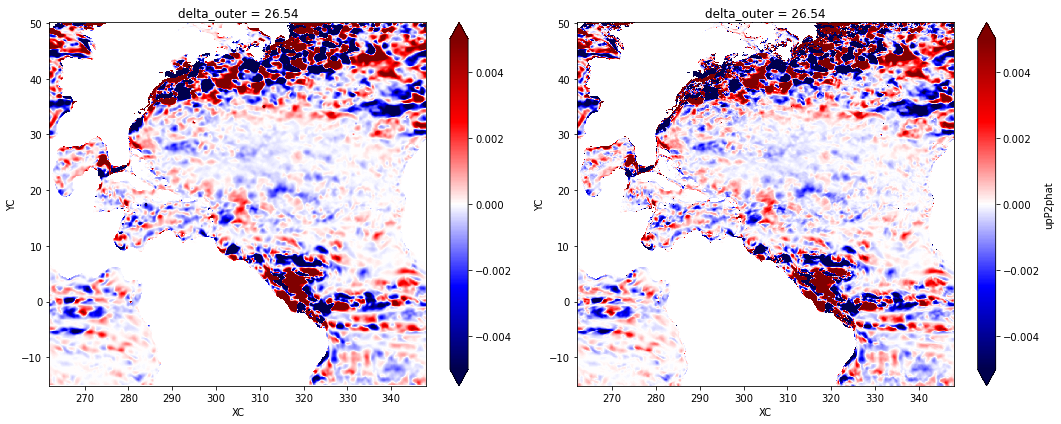

In [23]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

(upP2hat_sm).isel(delta_outer=23).plot(ax=ax1, vmax=5e-3, cmap='seismic', rasterized=True)
(dsFp.upP2phat
 # /grid.interp(ds.dyG,'X')
).isel(delta_outer=23).plot(ax=ax2, vmax=5e-3, cmap='seismic', rasterized=True)

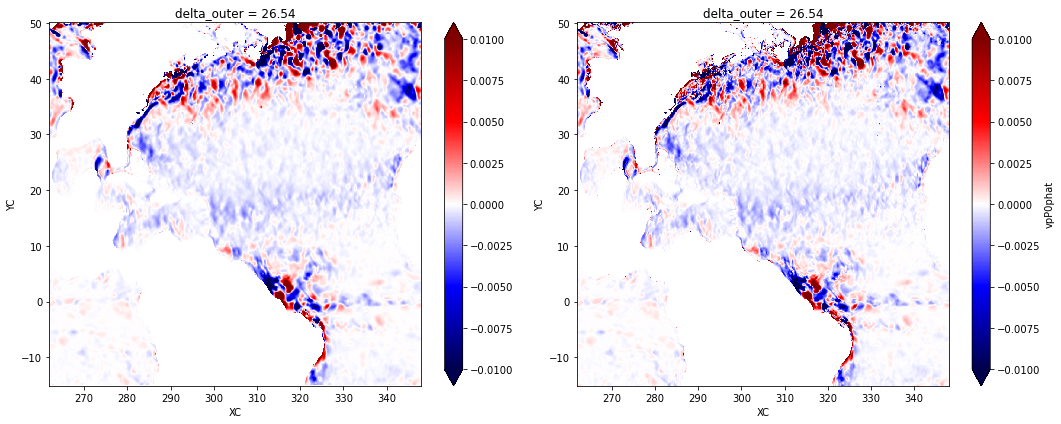

In [24]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

(vpP0hat_sm).isel(delta_outer=23).plot(ax=ax1, vmax=1e-2, cmap='seismic', rasterized=True)
(dsFp.vpP0phat
 # /grid.interp(ds.dxG,'Y',boundary='extend')
).isel(delta_outer=23).plot(ax=ax2, vmax=1e-2, cmap='seismic', rasterized=True)

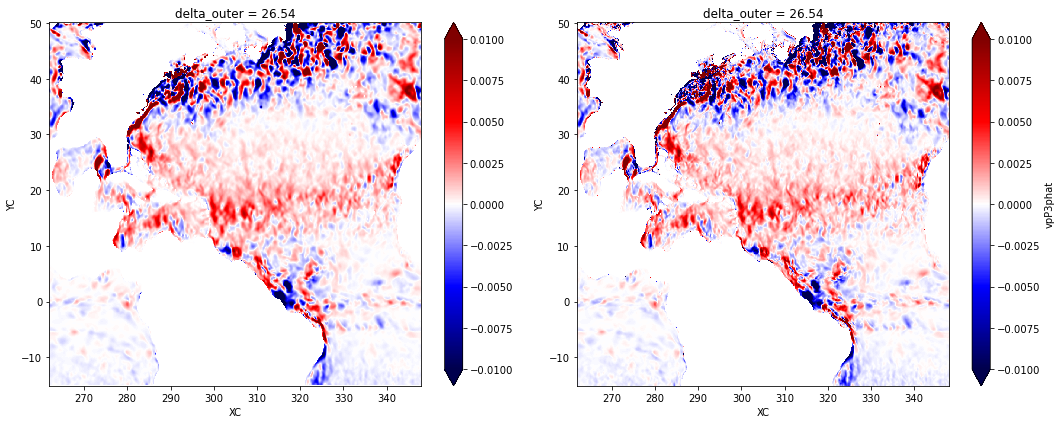

In [25]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

(vpP3hat_sm).isel(delta_outer=23).plot(ax=ax1, vmax=1e-2, cmap='seismic', rasterized=True)
(dsFp.vpP3phat
 # / grid.interp(ds.dxG,'Y',boundary='extend')
).isel(delta_outer=23).plot(ax=ax2, vmax=1e-2, cmap='seismic', rasterized=True)

In [21]:
upThat_sm = gauss_filter.apply((dsTp.upTphat.where(wet_mask!=0.)
                                 # /grid.interp(ds.dyG,'X')
                               ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
vpThat_sm = gauss_filter.apply((dsTp.vpTphat.where(wet_mask!=0.)
                                 # /grid.interp(ds.dxG,'Y',boundary='extend')
                               ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
upShat_sm = gauss_filter.apply((dsTp.upSphat.where(wet_mask!=0.)
                                 # /grid.interp(ds.dyG,'X')
                               ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])
vpShat_sm = gauss_filter.apply((dsTp.vpSphat.where(wet_mask!=0.)
                                 # /grid.interp(ds.dxG,'Y',boundary='extend')
                               ).chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])


upThat_raw = (dsTp.upTphat.where(wet_mask!=0.)
               # /grid.interp(ds.dyG,'X')
             )
vpThat_raw = (dsTp.vpTphat.where(wet_mask!=0.)
               # /grid.interp(ds.dxG,'Y',boundary='extend')
             )
upShat_raw = (dsTp.upSphat.where(wet_mask!=0.)
               # /grid.interp(ds.dyG,'X')
             )
vpShat_raw = (dsTp.vpSphat.where(wet_mask!=0.)
               # /grid.interp(ds.dxG,'Y',boundary='extend')
             )

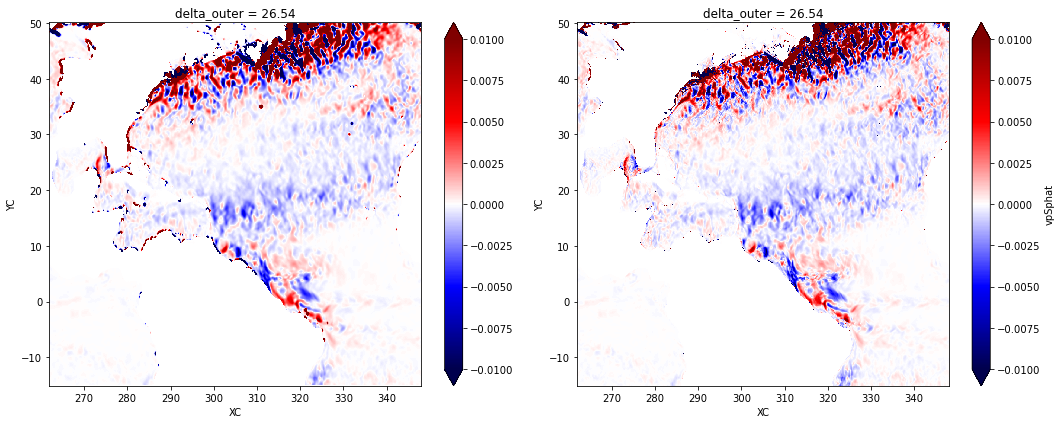

In [25]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

(vpShat_sm).isel(delta_outer=23).plot(ax=ax1, vmax=1e-2, cmap='seismic', rasterized=True)
(dsTp.vpSphat
 # / grid.interp(ds.dxG,'Y',boundary='extend')
).isel(delta_outer=23).plot(ax=ax2, vmax=1e-2, cmap='seismic', rasterized=True)

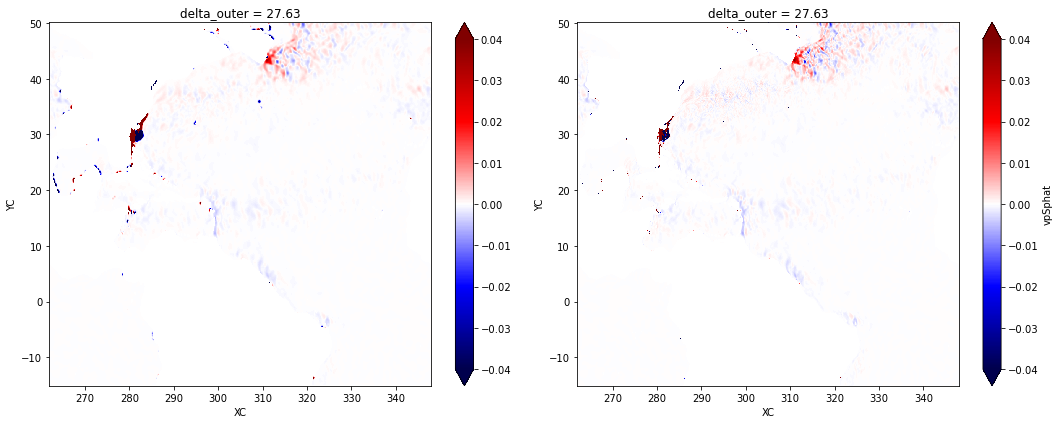

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

(vpShat_sm).isel(delta_outer=30).plot(ax=ax1, vmax=4e-2, cmap='seismic', rasterized=True)
(dsTp.vpSphat
 # / grid.interp(ds.dxG,'Y',boundary='extend')
).isel(delta_outer=30).plot(ax=ax2, vmax=4e-2, cmap='seismic', rasterized=True)

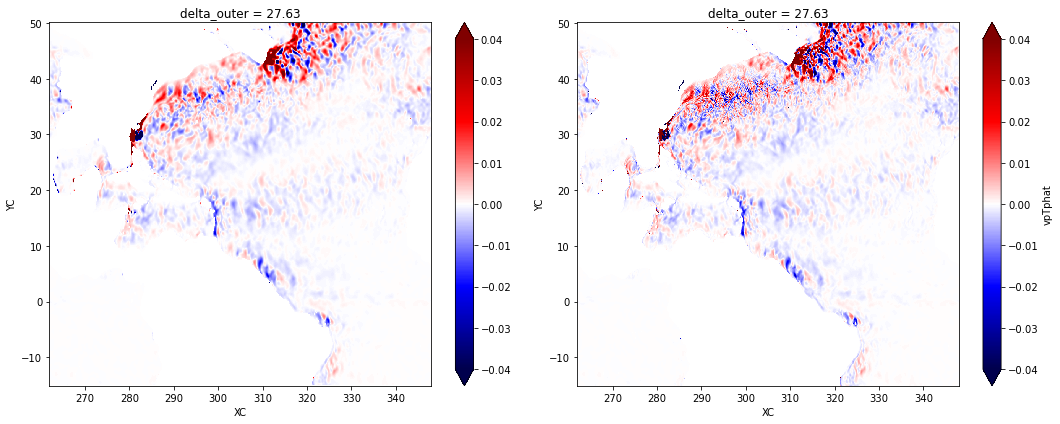

In [156]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

(vpThat_sm).isel(delta_outer=30).plot(ax=ax1, vmax=4e-2, cmap='seismic', rasterized=True)
(dsTp.vpTphat
 # / grid.interp(ds.dxG,'Y',boundary='extend')
).isel(delta_outer=30).plot(ax=ax2, vmax=4e-2, cmap='seismic', rasterized=True)

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,5))
fig.set_tight_layout(True)

PVpx.isel(delta_outer=23).plot(ax=ax1, vmax=1e-1, cmap='seismic', rasterized=True)
PVpx_sm.isel(delta_outer=23).plot(ax=ax2, vmax=1e-1, cmap='seismic', rasterized=True)

In [22]:
def _dot2D(self, other):
    func = np.dot(self[0,0], other[0,0])
#     return np.expand_dims(func, (0,1,2))
    return func[np.newaxis,np.newaxis,:,:]

(78, 100, 55)


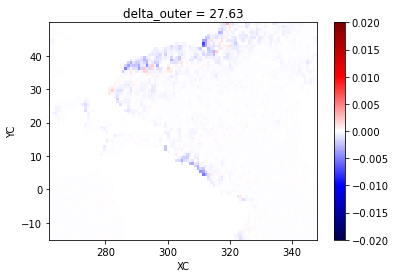

In [23]:
nC = 10
rAc = (ds.rA.where(wet_mask!=0.)
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC}, boundary='trim')
      ).sum(skipna=False) 
print(rAc.shape)
((vpP0hat_sm * ds.rA.where(wet_mask!=0.)).isel(delta_outer=30)
 .isel(YC=slice(1,-1))
 .coarsen({'YC':nC,'XC':nC}, boundary='trim').sum() 
 / rAc.isel(delta_outer=30)).plot(vmax=2e-2, cmap='seismic', rasterized=True)

Task exception was never retrieved
future: <Task finished name='Task-1185' coro=<Client._gather.<locals>.wait() done, defined at /tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/distributed/client.py:2007> exception=AllExit()>
Traceback (most recent call last):
  File "/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/distributed/client.py", line 2016, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-1186' coro=<Client._gather.<locals>.wait() done, defined at /tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/distributed/client.py:2007> exception=AllExit()>
Traceback (most recent call last):
  File "/tank/users/tuchida/miniconda3/envs/xgcm/lib/python3.9/site-packages/distributed/client.py", line 2016, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-1187' coro=<Client._gather.<local

13
14
15
16
17
18
19
20
21
22


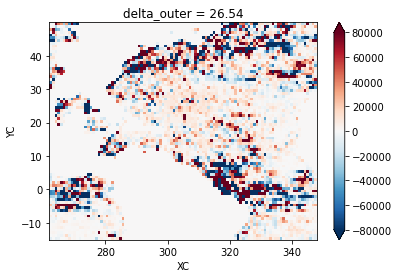

23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47


In [31]:
# xlim = [280,340]
dy = 0
# lstart = sstart + 2

for l in range(ts,bs):
# for l in range(23,24):
    uP0 = ((upP0hat_sm * ds.rA.where(wet_mask!=0.)
           ).isel(delta_outer=l).isel(YC=slice(1,-1)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
           / rAc.isel(delta_outer=l)).compute()
    vP0 = ((vpP0hat_sm * ds.rA.where(wet_mask!=0.)
           ).isel(delta_outer=l).isel(YC=slice(1,-1)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
           / rAc.isel(delta_outer=l)).compute()
    uP1 = ((upP1hat_sm * ds.rA.where(wet_mask!=0.)
           ).isel(delta_outer=l).isel(YC=slice(1,-1)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
           / rAc.isel(delta_outer=l)).compute()
    vP1 = ((vpP1hat_sm * ds.rA.where(wet_mask!=0.)
           ).isel(delta_outer=l).isel(YC=slice(1,-1)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
           / rAc.isel(delta_outer=l)).compute()
    uP2 = ((upP2hat_sm * ds.rA.where(wet_mask!=0.)
           ).isel(delta_outer=l).isel(YC=slice(1,-1)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
           / rAc.isel(delta_outer=l)).compute()
    vP2 = ((vpP2hat_sm * ds.rA.where(wet_mask!=0.)
           ).isel(delta_outer=l).isel(YC=slice(1,-1)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
           / rAc.isel(delta_outer=l)).compute()
    uP3 = ((upP3hat_sm * ds.rA.where(wet_mask!=0.)
           ).isel(delta_outer=l).isel(YC=slice(1,-1)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
           / rAc.isel(delta_outer=l)).compute()
    vP3 = ((vpP3hat_sm * ds.rA.where(wet_mask!=0.)
           ).isel(delta_outer=l).isel(YC=slice(1,-1)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
           / rAc.isel(delta_outer=l)).compute()
    
    P0x_sm = ((P0bsm_x * ds.rA.where(wet_mask!=0.)
              ).isel(delta_outer=l).isel(YC=slice(1,-1)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
              / rAc.isel(delta_outer=l)).compute()
    P0y_sm = ((P0bsm_y * ds.rA.where(wet_mask!=0.)
              ).isel(delta_outer=l).isel(YC=slice(1,-1)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
              / rAc.isel(delta_outer=l)).compute()
    P1x_sm = ((P1bsm_x * ds.rA.where(wet_mask!=0.)
              ).isel(delta_outer=l).isel(YC=slice(1,-1)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
              / rAc.isel(delta_outer=l)).compute()
    P1y_sm = ((P1bsm_y * ds.rA.where(wet_mask!=0.)
              ).isel(delta_outer=l).isel(YC=slice(1,-1)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
              / rAc.isel(delta_outer=l)).compute()
    P2x_sm = ((P2bsm_x * ds.rA.where(wet_mask!=0.)
              ).isel(delta_outer=l).isel(YC=slice(1,-1)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
              / rAc.isel(delta_outer=l)).compute()
    P2y_sm = ((P2bsm_y * ds.rA.where(wet_mask!=0.)
              ).isel(delta_outer=l).isel(YC=slice(1,-1)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
              / rAc.isel(delta_outer=l)).compute()
    P3x_sm = ((P3bsm_x * ds.rA.where(wet_mask!=0.)
              ).isel(delta_outer=l).isel(YC=slice(1,-1)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
              / rAc.isel(delta_outer=l)).compute()
    P3y_sm = ((P3bsm_y * ds.rA.where(wet_mask!=0.)
              ).isel(delta_outer=l).isel(YC=slice(1,-1)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
              / rAc.isel(delta_outer=l)).compute()
    
#################################
    u0_norm = (uP0 * np.nanmedian(np.sqrt(P0x_sm**2 + P0y_sm**2),
                                  axis=(0,1))**-1)
    v0_norm = (vP0 * np.nanmedian(np.sqrt(P0x_sm**2 + P0y_sm**2),
                                  axis=(0,1))**-1)
    u1_norm = (uP1 * np.nanmedian(np.sqrt(P1x_sm**2 + P1y_sm**2),
                                  axis=(0,1))**-1)
    v1_norm = (vP1 * np.nanmedian(np.sqrt(P1x_sm**2 + P1y_sm**2),
                                  axis=(0,1))**-1)
    u2_norm = (uP2 * np.nanmedian(np.sqrt(P2x_sm**2 + P2y_sm**2),
                                  axis=(0,1))**-1)
    v2_norm = (vP2 * np.nanmedian(np.sqrt(P2x_sm**2 + P2y_sm**2),
                                  axis=(0,1))**-1)
    u3_norm = (uP3 * np.nanmedian(np.sqrt(P3x_sm**2 + P3y_sm**2),
                                  axis=(0,1))**-1)
    v3_norm = (vP3 * np.nanmedian(np.sqrt(P3x_sm**2 + P3y_sm**2),
                                  axis=(0,1))**-1)
    
    P0x_norm = (P0x_sm * np.nanmedian(np.sqrt(P0x_sm**2 + P0y_sm**2), 
                                      axis=(0,1))**-1)
    P0y_norm = (P0y_sm * np.nanmedian(np.sqrt(P0x_sm**2 + P0y_sm**2), 
                                      axis=(0,1))**-1)
    P1x_norm = (P1x_sm * np.nanmedian(np.sqrt(P1x_sm**2 + P1y_sm**2), 
                                      axis=(0,1))**-1)
    P1y_norm = (P1y_sm * np.nanmedian(np.sqrt(P1x_sm**2 + P1y_sm**2), 
                                      axis=(0,1))**-1)
    P2x_norm = (P2x_sm * np.nanmedian(np.sqrt(P2x_sm**2 + P2y_sm**2), 
                                      axis=(0,1))**-1)
    P2y_norm = (P2y_sm * np.nanmedian(np.sqrt(P2x_sm**2 + P2y_sm**2), 
                                      axis=(0,1))**-1)
    P3x_norm = (P3x_sm * np.nanmedian(np.sqrt(P3x_sm**2 + P3y_sm**2), 
                                      axis=(0,1))**-1)
    P3y_norm = (P3y_sm * np.nanmedian(np.sqrt(P3x_sm**2 + P3y_sm**2), 
                                      axis=(0,1))**-1)
    
#################################
    if l == ts:
        K = xr.DataArray(np.ones((len(uP0.YC.data),
                                  len(uP0.XC.data),
                                  len(dsz.delta_outer.data),
                                  2,2))*np.nan,
                         dims=['YC','XC','delta_outer','col','row'],
                         coords={'YC':uP0.YC.data,
                                 'XC':uP0.XC.data,
                                 'delta_outer':dsz.delta_outer.data}
                        )
    
    G = xr.DataArray(np.zeros((len(uP0.YC.data),
                               len(uP0.XC.data),
                               4,2)),
                     dims=['YC','XC','row','col']
                    )
    G[:,:,0,0] = -P0x_norm
    G[:,:,0,1] = -P0y_norm
    G[:,:,1,0] = -P1x_norm
    G[:,:,1,1] = -P1y_norm
    G[:,:,2,0] = -P2x_norm
    G[:,:,2,1] = -P2y_norm
    G[:,:,3,0] = -P3x_norm
    G[:,:,3,1] = -P3y_norm
    
    G = G.fillna(0.)
    
    invG = xr.DataArray(dsar.map_blocks(np.linalg.pinv, 
                                        G.chunk({'YC':1,'XC':1}).data).compute(),
                        dims=['YC','XC','row','col']
                       )
    del G
    
    F = xr.DataArray(np.zeros((len(uP0.YC.data),
                               len(uP0.XC.data),
                               4,2)),
                     dims=['YC','XC','row','col']
                    )
    F[:,:,0,0] = u0_norm
    F[:,:,0,1] = v0_norm
    F[:,:,1,0] = u1_norm
    F[:,:,1,1] = v1_norm
    F[:,:,2,0] = u2_norm
    F[:,:,2,1] = v2_norm
    F[:,:,3,0] = u3_norm
    F[:,:,3,1] = v3_norm
    
    F = F.fillna(0.)
    
    # K.isel(delta_outer=l)[:] = dsar.map_blocks(_dot2D, invG.chunk({'YC':1,'XC':1}).data, 
    #                                            F.chunk({'YC':1,'XC':1}).data,
    #                                            chunks=(1,1,2,2)
    #                                           ).compute()
    K[dict(delta_outer=l)] = dsar.map_blocks(_dot2D, invG.chunk({'YC':1,'XC':1}).data, 
                                             F.chunk({'YC':1,'XC':1}).data,
                                             chunks=(1,1,2,2)
                                            ).compute()
    if l == 23:
        K.isel(delta_outer=l)[:,:,0,0].plot(vmax=8e4)
        plt.show()
    
    del F, invG
    print(l)
    
K.to_dataset(name='K').to_zarr(op.join(spec,
                                       # '5Dave/run%4d/Diff-tensor/Gauss-%2dkm_nC%02d_%02dN-%02dN/%010d.zarr'
                                       '5Dave/run%4d/Diff-tensor/unweighted/Gauss-%2dkm_nC%02d_%02dN-%02dN/%010d.zarr'
                                       # '5Dave/run%4d/Diff-tensor/explicit/Gauss-%2dkm_nC%02d_%02dN-%02dN/%010d.zarr'
                                       # '5Dave/run%4d/Diff-tensor/explicit/no-skipNaN/Gauss-%2dkm_nC%02d_%02dN-%02dN/%010d.zarr'
                                       % (year,filter_scale*1e-3,nC,ySstart+dy,yend,itime)),
                               mode='w')

In [ ]:
# xlim = [280,340]
dy = 0
# lstart = sstart + 2

for l in range(ts,bs):
# for l in range(23,24):
    uP0 = ((upP0hat_raw.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
           ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
           / rAc).compute()
    vP0 = ((vpP0hat_raw.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
           ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
           / rAc).compute()
    uP1 = ((upP1hat_raw.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
           ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
           / rAc).compute()
    vP1 = ((vpP1hat_raw.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
           ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
           / rAc).compute()
    uP2 = ((upP2hat_raw.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
           ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
           / rAc).compute()
    vP2 = ((vpP2hat_raw.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
           ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
           / rAc).compute()
    uP3 = ((upP3hat_raw.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
           ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
           / rAc).compute()
    vP3 = ((vpP3hat_raw.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
           ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
           / rAc).compute()
    
    P0x_sm = ((P0b_x.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
              ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
              / rAc).compute()
    P0y_sm = ((P0b_y.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
              ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
              / rAc).compute()
    P1x_sm = ((P1b_x.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
              ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
              / rAc).compute()
    P1y_sm = ((P1b_y.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
              ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
              / rAc).compute()
    P2x_sm = ((P2b_x.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
              ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
              / rAc).compute()
    P2y_sm = ((P2b_y.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
              ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
              / rAc).compute()
    P3x_sm = ((P3b_x.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
              ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
              / rAc).compute()
    P3y_sm = ((P3b_y.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
              ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
              / rAc).compute()
    
#################################
    u0_norm = (uP0 * np.nanmedian(np.sqrt(P0x_sm**2 + P0y_sm**2),
                                  axis=(0,1))**-1)
    v0_norm = (vP0 * np.nanmedian(np.sqrt(P0x_sm**2 + P0y_sm**2),
                                  axis=(0,1))**-1)
    u1_norm = (uP1 * np.nanmedian(np.sqrt(P1x_sm**2 + P1y_sm**2),
                                  axis=(0,1))**-1)
    v1_norm = (vP1 * np.nanmedian(np.sqrt(P1x_sm**2 + P1y_sm**2),
                                  axis=(0,1))**-1)
    u2_norm = (uP2 * np.nanmedian(np.sqrt(P2x_sm**2 + P2y_sm**2),
                                  axis=(0,1))**-1)
    v2_norm = (vP2 * np.nanmedian(np.sqrt(P2x_sm**2 + P2y_sm**2),
                                  axis=(0,1))**-1)
    u3_norm = (uP3 * np.nanmedian(np.sqrt(P3x_sm**2 + P3y_sm**2),
                                  axis=(0,1))**-1)
    v3_norm = (vP3 * np.nanmedian(np.sqrt(P3x_sm**2 + P3y_sm**2),
                                  axis=(0,1))**-1)
    
    P0x_norm = (P0x_sm * np.nanmedian(np.sqrt(P0x_sm**2 + P0y_sm**2), 
                                      axis=(0,1))**-1)
    P0y_norm = (P0y_sm * np.nanmedian(np.sqrt(P0x_sm**2 + P0y_sm**2), 
                                      axis=(0,1))**-1)
    P1x_norm = (P1x_sm * np.nanmedian(np.sqrt(P1x_sm**2 + P1y_sm**2), 
                                      axis=(0,1))**-1)
    P1y_norm = (P1y_sm * np.nanmedian(np.sqrt(P1x_sm**2 + P1y_sm**2), 
                                      axis=(0,1))**-1)
    P2x_norm = (P2x_sm * np.nanmedian(np.sqrt(P2x_sm**2 + P2y_sm**2), 
                                      axis=(0,1))**-1)
    P2y_norm = (P2y_sm * np.nanmedian(np.sqrt(P2x_sm**2 + P2y_sm**2), 
                                      axis=(0,1))**-1)
    P3x_norm = (P3x_sm * np.nanmedian(np.sqrt(P3x_sm**2 + P3y_sm**2), 
                                      axis=(0,1))**-1)
    P3y_norm = (P3y_sm * np.nanmedian(np.sqrt(P3x_sm**2 + P3y_sm**2), 
                                      axis=(0,1))**-1)
    
#################################
    if l == ts:
        K = xr.DataArray(np.ones((len(uP0.YC.data),
                                  len(uP0.XC.data),
                                  len(dsz.delta_outer.data),
                                  2,2))*np.nan,
                         dims=['YC','XC','delta_outer','col','row'],
                         coords={'YC':uP0.YC.data,
                                 'XC':uP0.XC.data,
                                 'delta_outer':dsz.delta_outer.data}
                        )
    
    G = xr.DataArray(np.zeros((len(uP0.YC.data),
                               len(uP0.XC.data),
                               4,2)),
                     dims=['YC','XC','row','col']
                    )
    G[:,:,0,0] = -P0x_norm
    G[:,:,0,1] = -P0y_norm
    G[:,:,1,0] = -P1x_norm
    G[:,:,1,1] = -P1y_norm
    G[:,:,2,0] = -P2x_norm
    G[:,:,2,1] = -P2y_norm
    G[:,:,3,0] = -P3x_norm
    G[:,:,3,1] = -P3y_norm
    
    G = G.fillna(0.)
    
    invG = xr.DataArray(dsar.map_blocks(np.linalg.pinv, 
                                        G.chunk({'YC':1,'XC':1}).data).compute(),
                        dims=['YC','XC','row','col']
                       )
    del G
    
    F = xr.DataArray(np.zeros((len(uP0.YC.data),
                               len(uP0.XC.data),
                               4,2)),
                     dims=['YC','XC','row','col']
                    )
    F[:,:,0,0] = u0_norm
    F[:,:,0,1] = v0_norm
    F[:,:,1,0] = u1_norm
    F[:,:,1,1] = v1_norm
    F[:,:,2,0] = u2_norm
    F[:,:,2,1] = v2_norm
    F[:,:,3,0] = u3_norm
    F[:,:,3,1] = v3_norm
    
    F = F.fillna(0.)
    
    K.isel(delta_outer=l)[:] = dsar.map_blocks(_dot2D, invG.chunk({'YC':1,'XC':1}).data, 
                                               F.chunk({'YC':1,'XC':1}).data,
                                               chunks=(1,1,2,2)
                                              ).compute()
    if l == 23:
        K.isel(delta_outer=l)[:,:,0,0].plot.contourf(levels=np.linspace(-1e5,1e5,20), extend='both', cmap='RdBu_r')
        plt.show()
    
    del F, invG
    print(l)
    
K.to_dataset(name='K').to_zarr(op.join(spec,
                                       '5Dave/run%4d/Diff-tensor/nC%02d_%02dN-%02dN/%010d.zarr' 
                                       % (year,nC,ySstart+dy,yend,itime)),
                               mode='w')

In [90]:
K = xr.open_zarr(op.join(spec,
                         '5Dave/run%4d/Diff-tensor/explicit/no-skipNaN/Gauss-%2dkm_nC%02d_%02dN-%02dN/%010d.zarr'
                         # '5Dave/run%4d/Diff-tensor/unweighted/Gauss-%2dkm_nC%02d_%02dN-%02dN/%010d.zarr'
                         # '5Dave/run%4d/Diff-tensor/Gauss-%2dkm_nC%02d_%02dN-%02dN/%010d.zarr' 
                         # '5Dave/run%4d/Diff-tensor/nC%02d_%02dN-%02dN/%010d.zarr' 
                         % (year,50,10,ySstart,yend,itime))
                         # % (year,10,ySstart,yend,itime))
                ).K
K

<xarray.DataArray 'K' (YC: 78, XC: 100, delta_outer: 55, col: 2, row: 2)>
dask.array<open_dataset-1f40cad5f94dd5ad45b5153cf638763bK, shape=(78, 100, 55, 2, 2), dtype=float64, chunksize=(39, 50, 28, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * XC           (XC) float32 262.4 263.2 264.1 265.0 ... 345.9 346.7 347.6
  * YC           (YC) float32 -14.62 -13.79 -12.96 -12.12 ... 47.88 48.71 49.54
  * delta_outer  (delta_outer) float64 20.0 20.35 20.69 ... 29.14 29.17 29.2
Dimensions without coordinates: col, row

In [91]:
zetabC = (((zetab * ds.rA).where(wet_mask!=0.)
           ).isel(YC=slice(1,-1)).coarsen({'YC':nC,'XC':nC},boundary='trim').sum() 
           / rAc)
maskCC = (ds.maskC.where(ds.maskC!=1.).isel(YC=slice(1,-1))).coarsen({'YC':nC,'XC':nC},boundary='trim').mean() 
maskCC

<xarray.DataArray 'maskC' (Z: 46, YC: 78, XC: 100)>
dask.array<mean_agg-aggregate, shape=(46, 78, 100), dtype=float64, chunksize=(46, 39, 25), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 262.4 263.2 264.1 265.0 ... 345.0 345.9 346.7 347.6
  * YC       (YC) float32 -14.62 -13.79 -12.96 -12.12 ... 47.88 48.71 49.54
  * Z        (Z) >f4 -3.047 -9.454 -16.36 ... -5.375e+03 -5.625e+03 -5.875e+03
    rA       (YC, XC) float32 dask.array<chunksize=(39, 25), meta=np.ndarray>
    Depth    (YC, XC) float32 dask.array<chunksize=(39, 25), meta=np.ndarray>
    drF      (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    PHrefC   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    hFacC    (Z, YC, XC) float32 dask.array<chunksize=(46, 39, 25), meta=np.ndarray>
    maskC    (Z, YC, XC) float64 dask.array<chunksize=(46, 39, 25), meta=np.ndarray>
    maskInC  (YC, XC) float64 dask.array<chunksize=(39, 25), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
Attributes:
    standard_name:  sea_binary_mask_at_t_location
    long_name:      mask denoting wet point at center

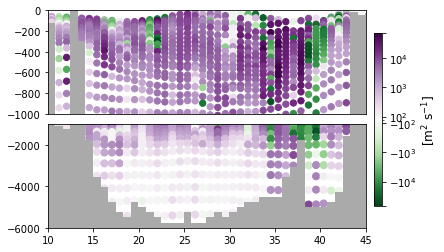

In [136]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1)

im = ax1.scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=300, method='nearest').data, 
           c=K.sel(XC=300, method='nearest')[:,:,0,0].data,
           s=40, 
           cmap='PRGn_r', 
           norm=clr.SymLogNorm(linthresh=linthresh, vmin=-7e4, vmax=7e4)
          )
ax2.scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=300, method='nearest').data, 
           c=K.sel(XC=300, method='nearest')[:,:,0,0].data,
           s=50, 
           cmap='PRGn_r', 
           norm=clr.SymLogNorm(linthresh=linthresh, vmin=-7e4, vmax=7e4)
          )

ax1.pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=300, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
ax2.pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=300, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)

ax1.set_ylim([-1000,0])
ax1.set_xlim([10,45])
ax1.set_xticks([])
ax2.set_ylim([None,-1000])
ax2.set_xlim([10,45])

fig.subplots_adjust(right=0.86, hspace=.1) 
cbax0 = fig.add_axes([0.88, 0.2, 0.018, 0.6])
cbar0 = fig.colorbar(im, orientation='vertical', cax=cbax0,
                     ticks=[-7e4,-1e4,-1e3,-1e2,1e2,1e3,1e4,7e4]
                     # ticks=[-1e5,-75e3,-50000,-25000,0,25000,50000,75000,100000]
                    )
cbar0.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(spec,'figure/Kappas00_XC=300_1967-01-01.pdf'))

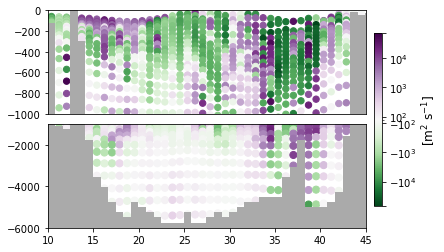

In [135]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1)

im = ax1.scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=300, method='nearest').data, 
           c=K.sel(XC=300, method='nearest')[:,:,0,1].data,
           s=40, 
           cmap='PRGn_r', 
           norm=clr.SymLogNorm(linthresh=linthresh, vmin=-7e4, vmax=7e4)
          )
ax2.scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=300, method='nearest').data, 
           c=K.sel(XC=300, method='nearest')[:,:,0,1].data,
           s=50, 
           cmap='PRGn_r', 
           norm=clr.SymLogNorm(linthresh=linthresh, vmin=-7e4, vmax=7e4)
          )

ax1.pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=300, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
ax2.pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=300, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)

ax1.set_ylim([-1000,0])
ax1.set_xlim([10,45])
ax1.set_xticks([])
ax2.set_ylim([None,-1000])
ax2.set_xlim([10,45])

fig.subplots_adjust(right=0.86, hspace=.1) 
cbax0 = fig.add_axes([0.88, 0.2, 0.018, 0.6])
cbar0 = fig.colorbar(im, orientation='vertical', cax=cbax0,
                     ticks=[-7e4,-1e4,-1e3,-1e2,1e2,1e3,1e4,7e4]
                     # ticks=[-1e5,-75e3,-50000,-25000,0,25000,50000,75000,100000]
                    )
cbar0.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(spec,'figure/Kappas01_XC=300_1967-01-01.pdf'))

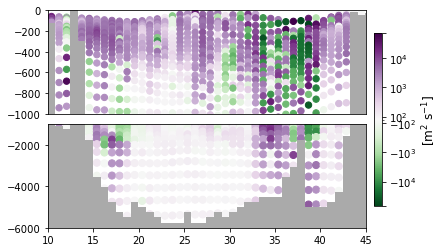

In [137]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1)

im = ax1.scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=300, method='nearest').data, 
           c=K.sel(XC=300, method='nearest')[:,:,1,1].data,
           s=40, 
           cmap='PRGn_r', 
           norm=clr.SymLogNorm(linthresh=linthresh, vmin=-7e4, vmax=7e4)
          )
ax2.scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=300, method='nearest').data, 
           c=K.sel(XC=300, method='nearest')[:,:,1,1].data,
           s=50, 
           cmap='PRGn_r', 
           norm=clr.SymLogNorm(linthresh=linthresh, vmin=-7e4, vmax=7e4)
          )

ax1.pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=300, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
ax2.pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=300, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)

ax1.set_ylim([-1000,0])
ax1.set_xlim([10,45])
ax1.set_xticks([])
ax2.set_ylim([None,-1000])
ax2.set_xlim([10,45])

fig.subplots_adjust(right=0.86, hspace=.1) 
cbax0 = fig.add_axes([0.88, 0.2, 0.018, 0.6])
cbar0 = fig.colorbar(im, orientation='vertical', cax=cbax0,
                     ticks=[-7e4,-1e4,-1e3,-1e2,1e2,1e3,1e4,7e4]
                     # ticks=[-1e5,-75e3,-50000,-25000,0,25000,50000,75000,100000]
                    )
cbar0.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(spec,'figure/Kappas11_XC=300_1967-01-01.pdf'))

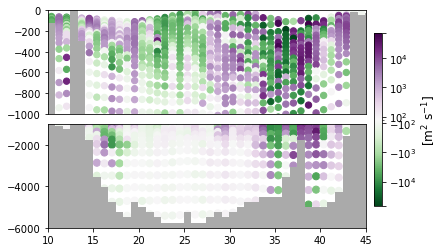

In [162]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1)

im = ax1.scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=300, method='nearest').data, 
           c=K.sel(XC=300, method='nearest')[:,:,1,0].data,
           s=40, 
           cmap='PRGn_r', 
           norm=clr.SymLogNorm(linthresh=linthresh, vmin=-7e4, vmax=7e4)
          )
ax2.scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=300, method='nearest').data, 
           c=K.sel(XC=300, method='nearest')[:,:,1,0].data,
           s=50, 
           cmap='PRGn_r', 
           norm=clr.SymLogNorm(linthresh=linthresh, vmin=-7e4, vmax=7e4)
          )

ax1.pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=300, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
ax2.pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=300, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)

ax1.set_ylim([-1000,0])
ax1.set_xlim([10,45])
ax1.set_xticks([])
ax2.set_ylim([None,-1000])
ax2.set_xlim([10,45])

fig.subplots_adjust(right=0.86, hspace=.1) 
cbax0 = fig.add_axes([0.88, 0.2, 0.018, 0.6])
cbar0 = fig.colorbar(im, orientation='vertical', cax=cbax0,
                     ticks=[-7e4,-1e4,-1e3,-1e2,1e2,1e3,1e4,7e4]
                     # ticks=[-1e5,-75e3,-50000,-25000,0,25000,50000,75000,100000]
                    )
cbar0.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)

plt.savefig(op.join(spec,'figure/Kappas10_XC=300_1967-01-01.pdf'))

In [46]:
l = 23
uP0 = ((upP0hat_sm * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False)
       / rAc.isel(delta_outer=l)).compute()
vP0 = ((vpP0hat_sm * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc.isel(delta_outer=l)).compute()
uP1 = ((upP1hat_sm * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc.isel(delta_outer=l)).compute()
vP1 = ((vpP1hat_sm * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc.isel(delta_outer=l)).compute()
uP2 = ((upP2hat_sm * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc.isel(delta_outer=l)).compute()
vP2 = ((vpP2hat_sm * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc.isel(delta_outer=l)).compute()
uP3 = ((upP3hat_sm * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc.isel(delta_outer=l)).compute()
vP3 = ((vpP3hat_sm * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc.isel(delta_outer=l)).compute()

P0x_sm = ((P0bsm_x * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc.isel(delta_outer=l)).compute()
P0y_sm = ((P0bsm_y * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc.isel(delta_outer=l)).compute()
P1x_sm = ((P1bsm_x * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc.isel(delta_outer=l)).compute()
P1y_sm = ((P1bsm_y * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc.isel(delta_outer=l)).compute()
P2x_sm = ((P2bsm_x * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc.isel(delta_outer=l)).compute()
P2y_sm = ((P2bsm_y * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc.isel(delta_outer=l)).compute()
P3x_sm = ((P3bsm_x * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc.isel(delta_outer=l)).compute()
P3y_sm = ((P3bsm_y * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc.isel(delta_outer=l)).compute()

In [55]:
l = 23
uT = ((upThat_sm * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
      .isel(YC=slice(1,-1))
      .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc.isel(delta_outer=l)).compute()
vT = ((vpThat_sm * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
      .isel(YC=slice(1,-1))
      .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc.isel(delta_outer=l)).compute()
uS = ((upShat_sm * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
      .isel(YC=slice(1,-1))
      .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc.isel(delta_outer=l)).compute()
vS = ((vpShat_sm * ds.rA.where(wet_mask!=0.)
       ).isel(delta_outer=l)
      .isel(YC=slice(1,-1))
      .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc.isel(delta_outer=l)).compute()

Tx_sm = ((thatsm_x * ds.rA.where(wet_mask!=0.)
         ).isel(delta_outer=l)
         .isel(YC=slice(1,-1))
         .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc.isel(delta_outer=l)).compute()
Ty_sm = ((thatsm_y * ds.rA.where(wet_mask!=0.)
         ).isel(delta_outer=l)
         .isel(YC=slice(1,-1))
         .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc.isel(delta_outer=l)).compute()
Sx_sm = ((shatsm_x * ds.rA.where(wet_mask!=0.)
         ).isel(delta_outer=l)
         .isel(YC=slice(1,-1))
         .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc.isel(delta_outer=l)).compute()
Sy_sm = ((shatsm_y * ds.rA.where(wet_mask!=0.)
         ).isel(delta_outer=l)
         .isel(YC=slice(1,-1))
         .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc.isel(delta_outer=l)).compute()

In [56]:
maskC = uT.to_masked_array().mask
maskC = np.ma.masked_array(vT.to_masked_array(),maskC).mask
# maskC.shape

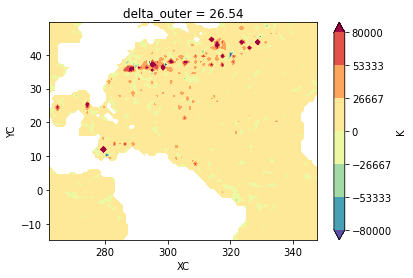

In [220]:
K.where(K!=0.).isel(delta_outer=23)[:,:,0,0].plot.contourf(vmax=8e4, cmap='Spectral_r')

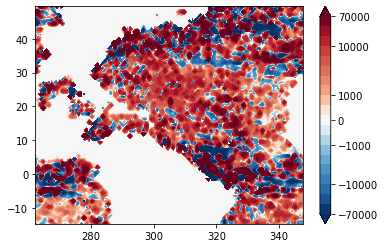

In [79]:
linthresh = 1e3
levs = -np.flip(np.logspace(np.log10(1e4),np.log10(7e4),num=4)[1:])
levs = np.concatenate((levs,-np.flip(np.logspace(np.log10(linthresh),np.log10(1e4),num=5))))
levs = np.concatenate((levs,np.linspace(-linthresh,linthresh,6)[1:-1]))
levs = np.concatenate((levs,np.logspace(np.log10(linthresh),np.log10(1e4),num=5,endpoint=False)))
levs = np.concatenate((levs,np.logspace(np.log10(1e4),np.log10(7e4),num=4)))

fig, ax = plt.subplots()
im = ax.contourf(K.XC, K.YC, 
                K.isel(delta_outer=23)[:,:,0,0], 
                cmap='RdBu_r', 
                levels = levs,
            # locator=mtick.SymmetricalLogLocator(base=10,linthresh=1e3),
                extend='both',
                norm=clr.SymLogNorm(linthresh=linthresh)
               )
cbar = plt.colorbar(im, ax=ax, ticks=[-7e4,-1e4,-1e3,0,1e3,1e4,7e4])

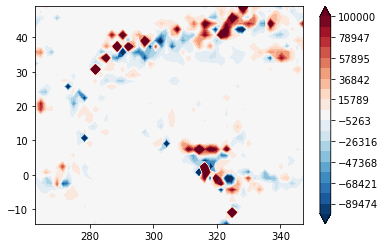

In [26]:
plt.contourf(K.XC, K.YC, 
             K.isel(delta_outer=23)[:,:,1,0], 
             cmap='RdBu_r', 
             levels = np.linspace(-1e5,1e5,20),
             # locator=mtick.SymmetricalLogLocator(base=10,linthresh=1e2)
             extend='both'
            )
plt.colorbar()

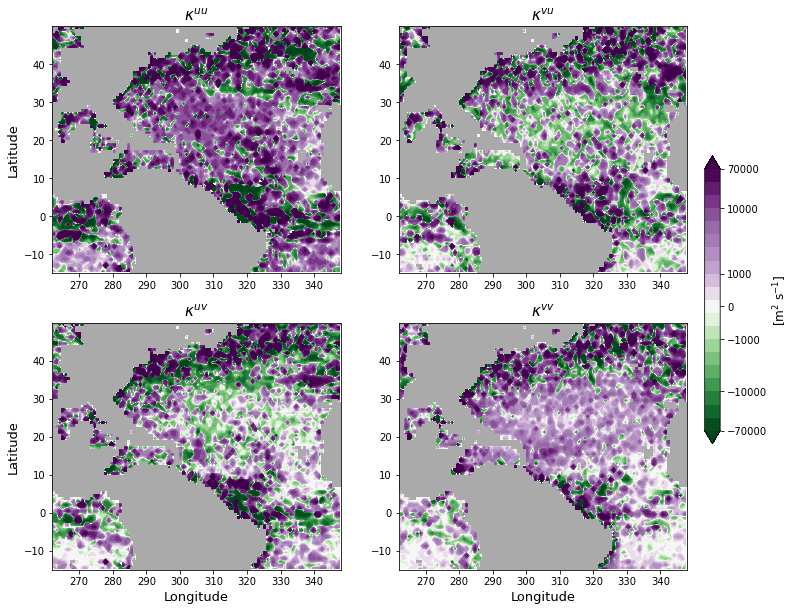

In [80]:
l = 23
maskK = np.ma.masked_values(np.ma.masked_invalid(K.isel(delta_outer=l)[:,:,0,0]),0.).mask
    
    
fig, axes = plt.subplots(figsize=(12,10), nrows=2, ncols=2)
        
im0 = axes[0,0].contourf(K.XC, K.YC, K.isel(delta_outer=l)[:,:,0,0], 
                         cmap='PRGn_r', 
                         # levels = np.linspace(-1e5,1e5,33), 
                         levels = levs,
                    # locator=mtick.SymmetricalLogLocator(base=10,linthresh=1e3),
                         extend='both',
                         norm=clr.SymLogNorm(linthresh=linthresh)
                        )
im1 = axes[0,1].contourf(K.XC, K.YC, K.isel(delta_outer=l)[:,:,0,1], 
                         cmap='PRGn_r', 
                         # levels = np.linspace(-1e5,1e5,33), 
                         levels = levs,
                    # locator=mtick.SymmetricalLogLocator(base=10,linthresh=1e3),
                         extend='both',
                         norm=clr.SymLogNorm(linthresh=linthresh)
                        )
im2 = axes[1,0].contourf(K.XC, K.YC, K.isel(delta_outer=l)[:,:,1,0], 
                         cmap='PRGn_r', 
                         # levels = np.linspace(-1e5,1e5,33), 
                         levels = levs,
                    # locator=mtick.SymmetricalLogLocator(base=10,linthresh=1e3),
                         extend='both',
                         norm=clr.SymLogNorm(linthresh=linthresh)
                        )
im3 = axes[1,1].contourf(K.XC, K.YC, K.isel(delta_outer=l)[:,:,1,1], 
                         cmap='PRGn_r', 
                         # levels = np.linspace(-1e5,1e5,33), 
                         levels = levs,
                    # locator=mtick.SymmetricalLogLocator(base=10,linthresh=1e3),
                         extend='both',
                         norm=clr.SymLogNorm(linthresh=linthresh)
                        )

for c in im0.collections:
    c.set_rasterized(True)
for c in im1.collections:
    c.set_rasterized(True)
for c in im2.collections:
    c.set_rasterized(True)
for c in im3.collections:
    c.set_rasterized(True)
# im0 = axes[0,0].pcolormesh(K.XC, K.YC, K.isel(delta_outer=l)[:,:,0,0], 
#                          cmap='bwr', 
#                          rasterized=True,
#                          norm=clr.SymLogNorm(linthresh=5e2, vmin=-8e4, vmax=8e4)
#                         )
# im1 = axes[0,1].pcolormesh(K.XC, K.YC, K.isel(delta_outer=l)[:,:,0,1], 
#                          cmap='bwr', 
#                          rasterized=True,
#                          norm=clr.SymLogNorm(linthresh=5e2, vmin=-8e4, vmax=8e4)
#                         )
# im2 = axes[1,0].pcolormesh(K.XC, K.YC, K.isel(delta_outer=l)[:,:,1,0], 
#                          cmap='bwr', 
#                          rasterized=True,
#                          norm=clr.SymLogNorm(linthresh=5e2, vmin=-8e4, vmax=8e4)
#                         )
# im3 = axes[1,1].pcolormesh(K.XC, K.YC, K.isel(delta_outer=l)[:,:,1,1], 
#                          cmap='bwr', 
#                          rasterized=True,
#                          norm=clr.SymLogNorm(linthresh=5e2, vmin=-8e4, vmax=8e4)
#                         )

        
axes[0,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(K.XC, K.YC,
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)

axes[0,0].set_title(r"$\kappa^{uu}$", fontsize=15)
axes[0,1].set_title(r"$\kappa^{vu}$", fontsize=15)
axes[1,0].set_title(r"$\kappa^{uv}$", fontsize=15)
axes[1,1].set_title(r"$\kappa^{vv}$", fontsize=15)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.2) 
cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0,
                     ticks=[-7e4,-1e4,-1e3,0,1e3,1e4,7e4]
                     # ticks=[-1e5,-75e3,-50000,-25000,0,25000,50000,75000,100000]
                    )
cbar0.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)
# plt.savefig(op.join(spec,'figure/Kappas-explicit_l=%2d_1967-01-01.pdf' % l))
plt.savefig(op.join(spec,'figure/Kappas_l=%2d_1967-01-01.pdf' % l))

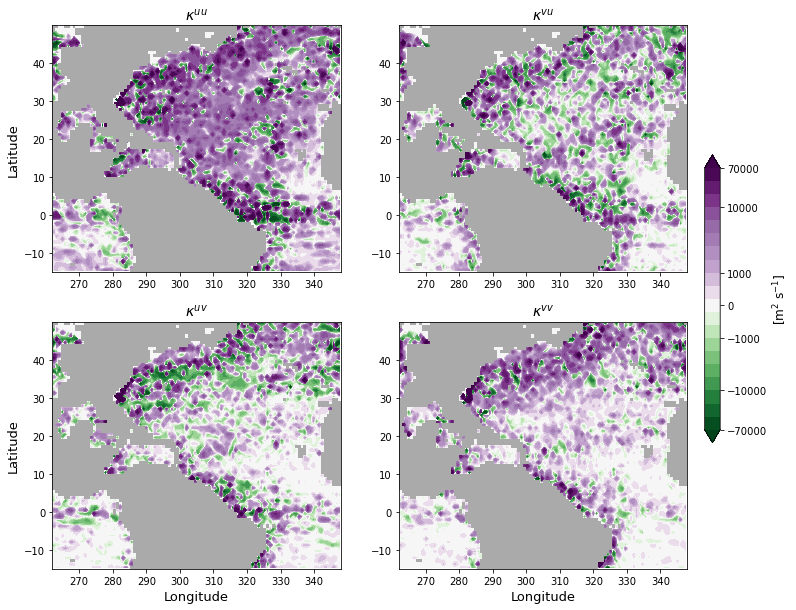

In [81]:
l = 30
maskK = np.ma.masked_values(np.ma.masked_invalid(K.isel(delta_outer=l)[:,:,0,0]),0.).mask
    
    
fig, axes = plt.subplots(figsize=(12,10), nrows=2, ncols=2)
        
im0 = axes[0,0].contourf(K.XC, K.YC, K.isel(delta_outer=l)[:,:,0,0], 
                         cmap='PRGn_r', 
                         # levels = np.linspace(-1e5,1e5,33), 
                         levels = levs,
                    # locator=mtick.SymmetricalLogLocator(base=10,linthresh=1e3),
                         extend='both',
                         norm=clr.SymLogNorm(linthresh=linthresh)
                        )
im1 = axes[0,1].contourf(K.XC, K.YC, K.isel(delta_outer=l)[:,:,0,1], 
                         cmap='PRGn_r', 
                         # levels = np.linspace(-1e5,1e5,33), 
                         levels = levs,
                    # locator=mtick.SymmetricalLogLocator(base=10,linthresh=1e3),
                         extend='both',
                         norm=clr.SymLogNorm(linthresh=linthresh)
                        )
im2 = axes[1,0].contourf(K.XC, K.YC, K.isel(delta_outer=l)[:,:,1,0], 
                         cmap='PRGn_r', 
                         # levels = np.linspace(-1e5,1e5,33), 
                         levels = levs,
                    # locator=mtick.SymmetricalLogLocator(base=10,linthresh=1e3),
                         extend='both',
                         norm=clr.SymLogNorm(linthresh=linthresh)
                        )
im3 = axes[1,1].contourf(K.XC, K.YC, K.isel(delta_outer=l)[:,:,1,1], 
                         cmap='PRGn_r', 
                         # levels = np.linspace(-1e5,1e5,33), 
                         levels = levs,
                    # locator=mtick.SymmetricalLogLocator(base=10,linthresh=1e3),
                         extend='both',
                         norm=clr.SymLogNorm(linthresh=linthresh)
                        )

for c in im0.collections:
    c.set_rasterized(True)
for c in im1.collections:
    c.set_rasterized(True)
for c in im2.collections:
    c.set_rasterized(True)
for c in im3.collections:
    c.set_rasterized(True)
        
axes[0,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(K.XC, K.YC,
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)

axes[0,0].set_title(r"$\kappa^{uu}$", fontsize=14)
axes[0,1].set_title(r"$\kappa^{vu}$", fontsize=14)
axes[1,0].set_title(r"$\kappa^{uv}$", fontsize=14)
axes[1,1].set_title(r"$\kappa^{vv}$", fontsize=14)

axes[1,0].set_xlabel(r"Longitude", fontsize=13)
axes[1,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.2) 
cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0,
                     ticks=[-7e4,-1e4,-1e3,0,1e3,1e4,7e4]
                     # ticks=[-1e5,-75e3,-50000,-25000,0,25000,50000,75000,100000]
                    )
cbar0.set_label(r"[m$^2$ s$^{-1}$]", fontsize=12)
# plt.savefig(op.join(spec,'figure/Kappas-explicit_l=%2d_1967-01-01.pdf' % l))
plt.savefig(op.join(spec,'figure/Kappas_l=%2d_1967-01-01.pdf' % l))

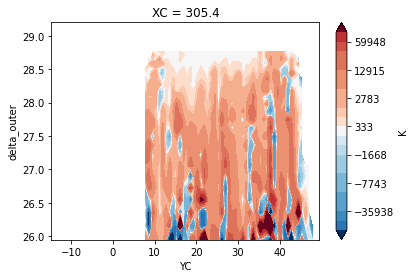

In [28]:
maskK = np.ma.masked_values(np.ma.masked_invalid(K.sel(XC=305,method='nearest')[...,0,0]),0.).mask
K.sel(XC=305,method='nearest')[...,0,0].where(maskK!=1.).isel(delta_outer=slice(20,None)
                                                             ).plot.contourf(y='delta_outer', levels=levs,
                    # locator=mtick.SymmetricalLogLocator(base=10,linthresh=1e3),
                         extend='both',
                         norm=clr.SymLogNorm(linthresh=linthresh))

In [40]:
l = 23
uP0 = ((upP0hat_raw.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
       ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
       / rAc).compute()
vP0 = ((vpP0hat_raw.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
       ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
       / rAc).compute()
uP1 = ((upP1hat_raw.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
       ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
       / rAc).compute()
vP1 = ((vpP1hat_raw.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
       ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
       / rAc).compute()
uP2 = ((upP2hat_raw.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
       ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
       / rAc).compute()
vP2 = ((vpP2hat_raw.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
       ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
       / rAc).compute()
uP3 = ((upP3hat_raw.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
       ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
       / rAc).compute()
vP3 = ((vpP3hat_raw.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
       ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
       / rAc).compute()

P0x_sm = ((P0b_x.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
          ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
          / rAc).compute()
P0y_sm = ((P0b_y.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
          ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
          / rAc).compute()
P1x_sm = ((P1b_x.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
          ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
          / rAc).compute()
P1y_sm = ((P1b_y.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
          ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
          / rAc).compute()
P2x_sm = ((P2b_x.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
          ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
          / rAc).compute()
P2y_sm = ((P2b_y.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
          ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
          / rAc).compute()
P3x_sm = ((P3b_x.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
          ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
          / rAc).compute()
P3y_sm = ((P3b_y.isel(delta_outer=l) * ds.rA.where(ds.maskInC!=0.)
          ).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True) 
          / rAc).compute()

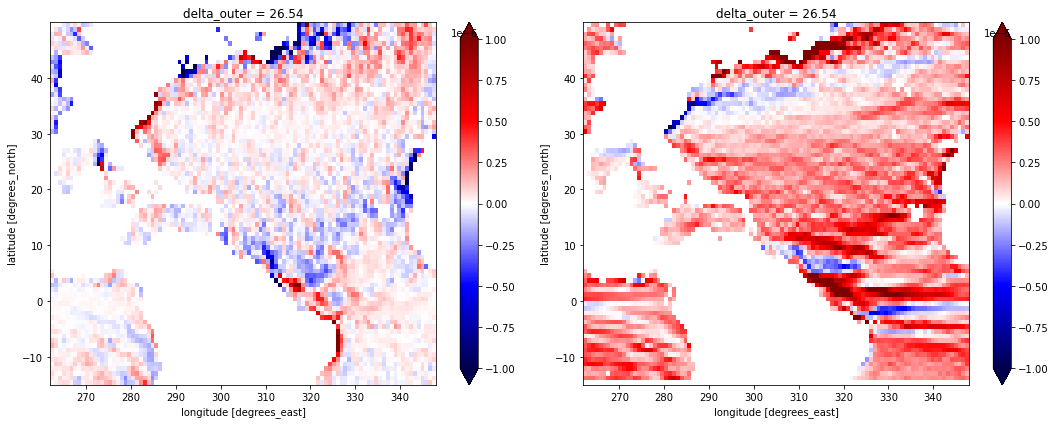

In [170]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

(P0x_sm).plot(ax=ax1, vmax=1e-6, cmap='seismic', rasterized=True)
(P0y_sm).plot(ax=ax2, vmax=1e-6, cmap='seismic', rasterized=True)

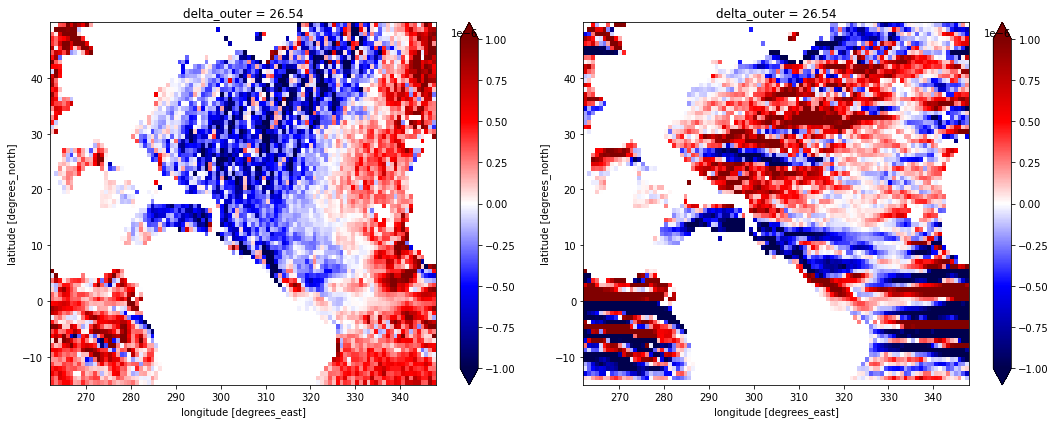

In [171]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

(P1x_sm).plot(ax=ax1, vmax=1e-6, cmap='seismic', rasterized=True)
(P1y_sm).plot(ax=ax2, vmax=1e-6, cmap='seismic', rasterized=True)

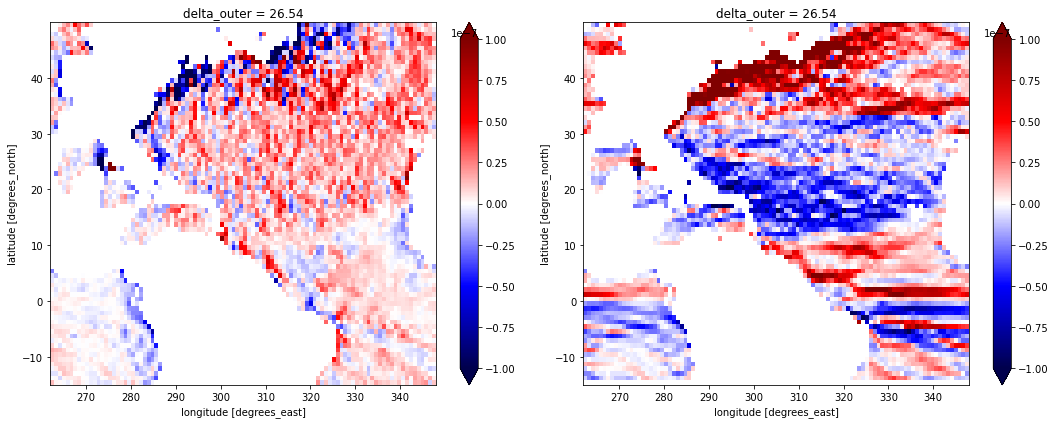

In [172]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

(P2x_sm).plot(ax=ax1, vmax=1e-7, cmap='seismic', rasterized=True)
(P2y_sm).plot(ax=ax2, vmax=1e-7, cmap='seismic', rasterized=True)

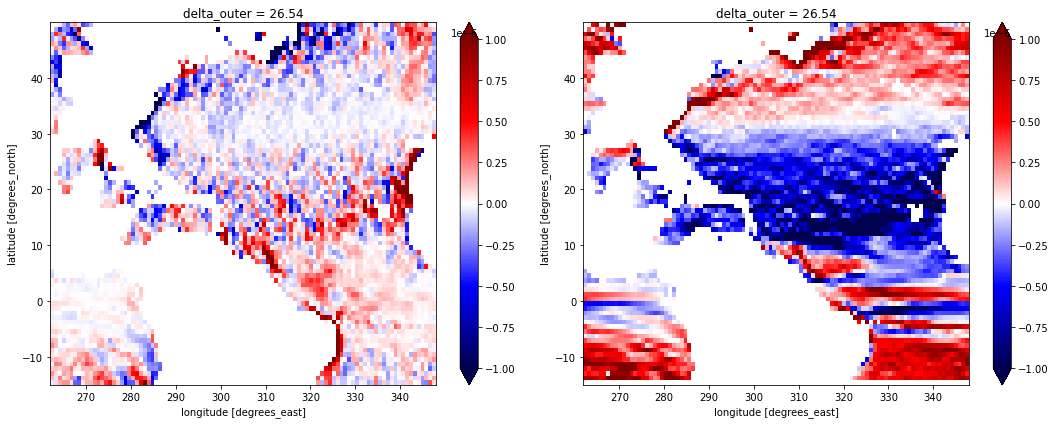

In [173]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

(P3x_sm).plot(ax=ax1, vmax=1e-6, cmap='seismic', rasterized=True)
(P3y_sm).plot(ax=ax2, vmax=1e-6, cmap='seismic', rasterized=True)

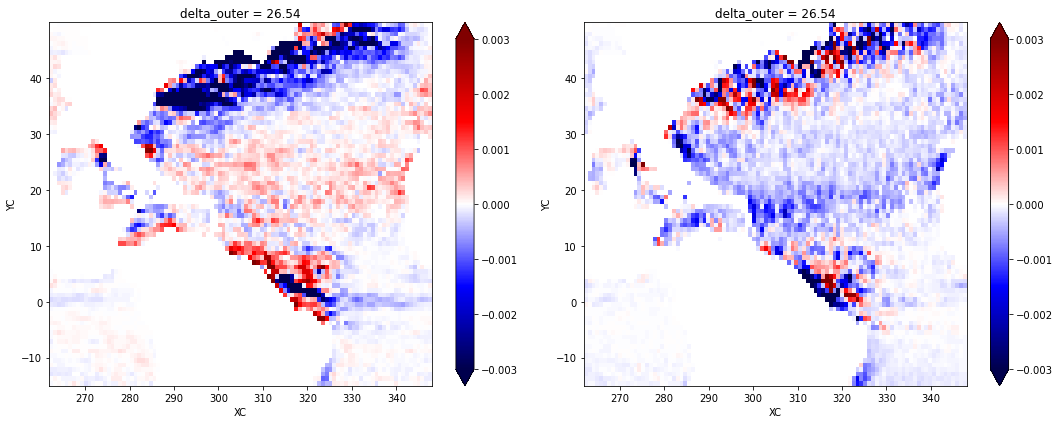

In [174]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

(uP0).plot(ax=ax1, vmax=3e-3, cmap='seismic', rasterized=True)
(vP0).plot(ax=ax2, vmax=3e-3, cmap='seismic', rasterized=True)

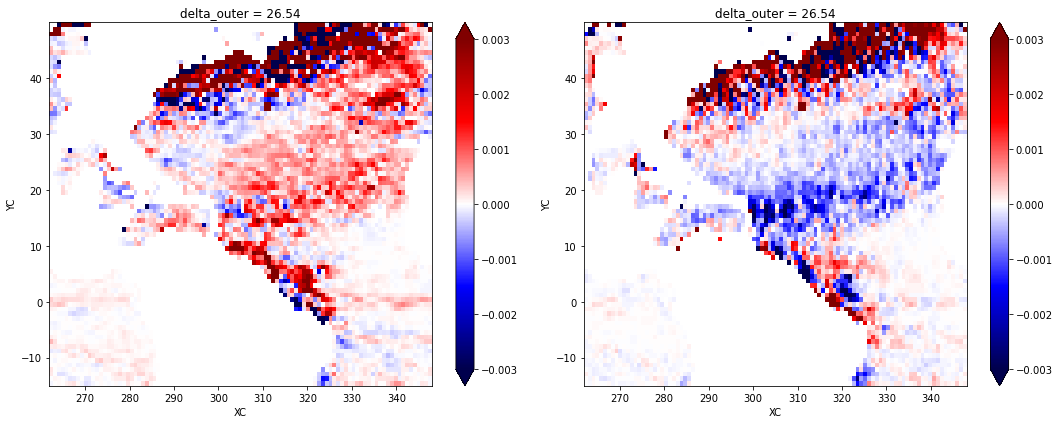

In [175]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.set_tight_layout(True)

(uS).plot(ax=ax1, vmax=3e-3, cmap='seismic', rasterized=True)
(vS).plot(ax=ax2, vmax=3e-3, cmap='seismic', rasterized=True)

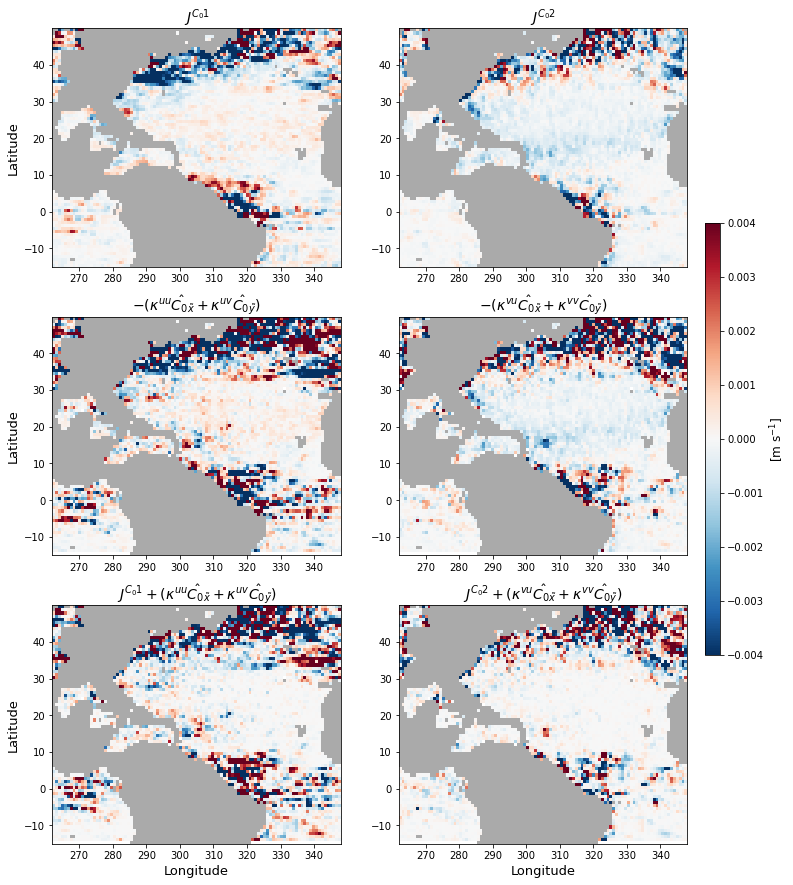

In [42]:
# maskK = np.ma.masked_invalid(K.isel(delta_outer=l)[:,:,0,0]).mask
maskK = np.ma.masked_values(np.ma.masked_invalid(K.isel(delta_outer=l)[:,:,0,0]),0.).mask
vlim = 4e-3
    
fig, axes = plt.subplots(figsize=(12,15), nrows=3, ncols=2)
        
# im0 = axes[0,0].contourf(K.XC, K.YC, uP0, 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im1 = axes[0,1].contourf(K.XC, K.YC, vP0, 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im2 = axes[1,0].contourf(K.XC, K.YC, 
#                            -(K.isel(delta_outer=l)[:,:,0,0] 
#                              * P0x_sm
#                              + K.isel(delta_outer=l)[:,:,1,0] 
#                              * P0y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im3 = axes[1,1].contourf(K.XC, K.YC, 
#                            -(K.isel(delta_outer=l)[:,:,0,1] 
#                              * P0x_sm
#                              + K.isel(delta_outer=l)[:,:,1,1] 
#                              * P0y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im4 = axes[2,0].contourf(K.XC, K.YC, 
#                          uP0 + (K.isel(delta_outer=l)[:,:,0,0] 
#                              * P0x_sm
#                              + K.isel(delta_outer=l)[:,:,1,0] 
#                              * P0y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im5 = axes[2,1].contourf(K.XC, K.YC, 
#                          vP0 + (K.isel(delta_outer=l)[:,:,0,1] 
#                              * P0x_sm
#                              + K.isel(delta_outer=l)[:,:,1,1] 
#                              * P0y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )

# for c in im0.collections:
#     c.set_rasterized(True)
# for c in im1.collections:
#     c.set_rasterized(True)
# for c in im2.collections:
#     c.set_rasterized(True)
# for c in im3.collections:
#     c.set_rasterized(True)
# for c in im4.collections:
#     c.set_rasterized(True)
# for c in im5.collections:
#     c.set_rasterized(True)

im0 = axes[0,0].pcolormesh(K.XC, K.YC, uP0, 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im1 = axes[0,1].pcolormesh(K.XC, K.YC, vP0, 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im2 = axes[1,0].pcolormesh(K.XC, K.YC, 
                           -(K.isel(delta_outer=l)[:,:,0,0] 
                             * P0x_sm
                             + K.isel(delta_outer=l)[:,:,1,0] 
                             * P0y_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im3 = axes[1,1].pcolormesh(K.XC, K.YC, 
                           -(K.isel(delta_outer=l)[:,:,0,1] 
                             * P0x_sm
                             + K.isel(delta_outer=l)[:,:,1,1] 
                             * P0y_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im4 = axes[2,0].pcolormesh(K.XC, K.YC, 
                         uP0 + (K.isel(delta_outer=l)[:,:,0,0] 
                             * P0x_sm
                             + K.isel(delta_outer=l)[:,:,1,0] 
                             * P0y_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im5 = axes[2,1].pcolormesh(K.XC, K.YC, 
                         vP0 + (K.isel(delta_outer=l)[:,:,0,1] 
                             * P0x_sm
                             + K.isel(delta_outer=l)[:,:,1,1] 
                             * P0y_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )


axes[0,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(K.XC, K.YC,
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,1].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)

axes[0,0].set_title(r"$J^{C_01}$", fontsize=14)
axes[0,1].set_title(r"$J^{C_02}$", fontsize=14)
axes[1,0].set_title(r"$-(\kappa^{uu}\hat{C_0}_\tilde{x} + \kappa^{uv} \hat{C_0}_\tilde{y})$", fontsize=14)
axes[1,1].set_title(r"$-(\kappa^{vu}\hat{C_0}_\tilde{x} + \kappa^{vv} \hat{C_0}_\tilde{y})$", fontsize=14)
axes[2,0].set_title(r"$J^{C_01}+(\kappa^{uu}\hat{C_0}_\tilde{x} + \kappa^{uv} \hat{C_0}_\tilde{y})$", fontsize=14)
axes[2,1].set_title(r"$J^{C_02}+(\kappa^{vu}\hat{C_0}_\tilde{x} + \kappa^{vv} \hat{C_0}_\tilde{y})$", fontsize=14)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.21) 
cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0, 
                         # ticks=[-30000,-20000,-10000,0,10000,20000,30000]
                    )
cbar0.set_label(r"[m s$^{-1}$]", fontsize=12)
# plt.savefig(op.join(spec,'figure/JC0-explicit_l=%2d_1967-01-01.pdf' % l))
plt.savefig(op.join(spec,'figure/JC0_l=%2d_1967-01-01.pdf' % l))

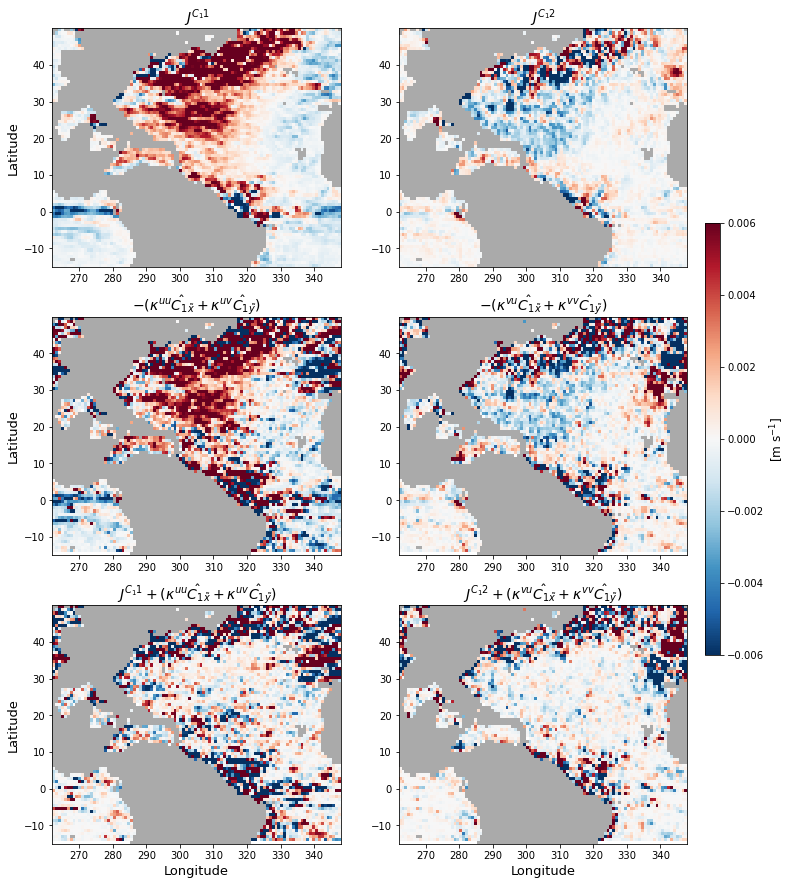

In [43]:
# maskK = np.ma.masked_invalid(K.isel(delta_outer=l)[:,:,0,0]).mask
maskK = np.ma.masked_values(np.ma.masked_invalid(K.isel(delta_outer=l)[:,:,0,0]),0.).mask
vlim = 6e-3
    
fig, axes = plt.subplots(figsize=(12,15), nrows=3, ncols=2)
        
# im0 = axes[0,0].contourf(K.XC, K.YC, uP1, 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im1 = axes[0,1].contourf(K.XC, K.YC, vP1, 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im2 = axes[1,0].contourf(K.XC, K.YC, 
#                            -(K.isel(delta_outer=l)[:,:,0,0] 
#                              * P1x_sm
#                              + K.isel(delta_outer=l)[:,:,1,0] 
#                              * P1y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im3 = axes[1,1].contourf(K.XC, K.YC, 
#                            -(K.isel(delta_outer=l)[:,:,0,1] 
#                              * P1x_sm
#                              + K.isel(delta_outer=l)[:,:,1,1] 
#                              * P1y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im4 = axes[2,0].contourf(K.XC, K.YC, 
#                          uP1 + (K.isel(delta_outer=l)[:,:,0,0] 
#                              * P1x_sm
#                              + K.isel(delta_outer=l)[:,:,1,0] 
#                              * P1y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im5 = axes[2,1].contourf(K.XC, K.YC, 
#                          vP1 + (K.isel(delta_outer=l)[:,:,0,1] 
#                              * P1x_sm
#                              + K.isel(delta_outer=l)[:,:,1,1] 
#                              * P1y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )

# for c in im0.collections:
#     c.set_rasterized(True)
# for c in im1.collections:
#     c.set_rasterized(True)
# for c in im2.collections:
#     c.set_rasterized(True)
# for c in im3.collections:
#     c.set_rasterized(True)
# for c in im4.collections:
#     c.set_rasterized(True)
# for c in im5.collections:
#     c.set_rasterized(True)

im0 = axes[0,0].pcolormesh(K.XC, K.YC, uP1, 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im1 = axes[0,1].pcolormesh(K.XC, K.YC, vP1, 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im2 = axes[1,0].pcolormesh(K.XC, K.YC, 
                           -(K.isel(delta_outer=l)[:,:,0,0] 
                             * P1x_sm
                             + K.isel(delta_outer=l)[:,:,1,0] 
                             * P1y_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im3 = axes[1,1].pcolormesh(K.XC, K.YC, 
                           -(K.isel(delta_outer=l)[:,:,0,1] 
                             * P1x_sm
                             + K.isel(delta_outer=l)[:,:,1,1] 
                             * P1y_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im4 = axes[2,0].pcolormesh(K.XC, K.YC, 
                         uP1 + (K.isel(delta_outer=l)[:,:,0,0] 
                             * P1x_sm
                             + K.isel(delta_outer=l)[:,:,1,0] 
                             * P1y_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im5 = axes[2,1].pcolormesh(K.XC, K.YC, 
                         vP1 + (K.isel(delta_outer=l)[:,:,0,1] 
                             * P1x_sm
                             + K.isel(delta_outer=l)[:,:,1,1] 
                             * P1y_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )


axes[0,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(K.XC, K.YC,
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,1].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)

axes[0,0].set_title(r"$J^{C_11}$", fontsize=14)
axes[0,1].set_title(r"$J^{C_12}$", fontsize=14)
axes[1,0].set_title(r"$-(\kappa^{uu}\hat{C_1}_\tilde{x} + \kappa^{uv} \hat{C_1}_\tilde{y})$", fontsize=14)
axes[1,1].set_title(r"$-(\kappa^{vu}\hat{C_1}_\tilde{x} + \kappa^{vv} \hat{C_1}_\tilde{y})$", fontsize=14)
axes[2,0].set_title(r"$J^{C_11}+(\kappa^{uu}\hat{C_1}_\tilde{x} + \kappa^{uv} \hat{C_1}_\tilde{y})$", fontsize=14)
axes[2,1].set_title(r"$J^{C_12}+(\kappa^{vu}\hat{C_1}_\tilde{x} + \kappa^{vv} \hat{C_1}_\tilde{y})$", fontsize=14)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.21) 
cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0, 
                         # ticks=[-30000,-20000,-10000,0,10000,20000,30000]
                    )
cbar0.set_label(r"[m s$^{-1}$]", fontsize=12)
# plt.savefig(op.join(spec,'figure/JC1-explicit_l=%2d_1967-01-01.pdf' % l))
plt.savefig(op.join(spec,'figure/JC1_l=%2d_1967-01-01.pdf' % l))

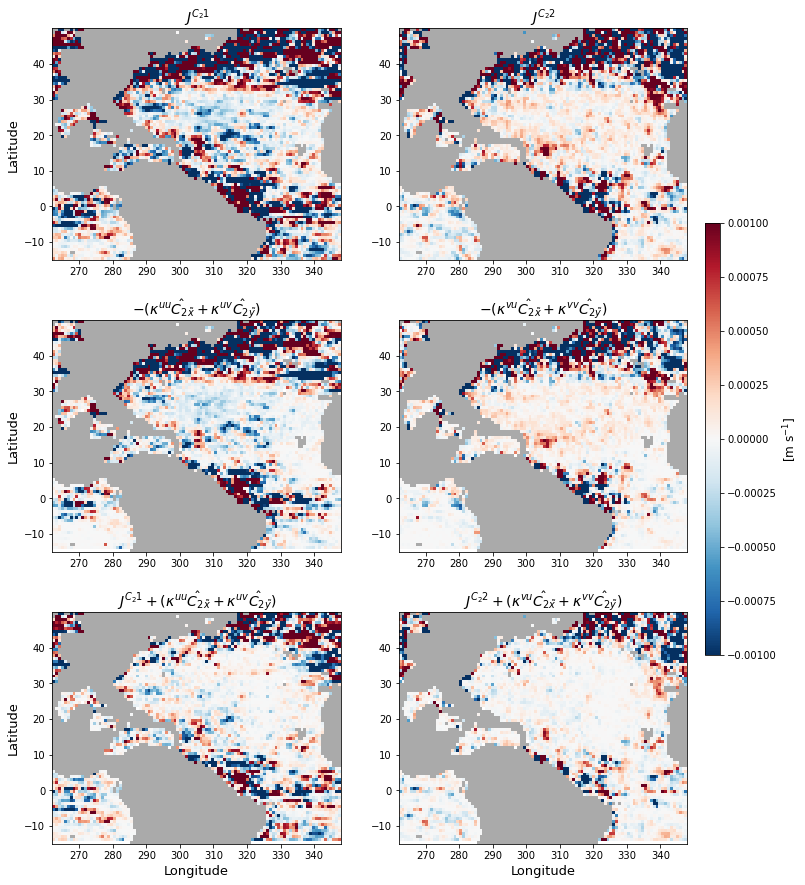

In [44]:
# maskK = np.ma.masked_invalid(K.isel(delta_outer=l)[:,:,0,0]).mask
maskK = np.ma.masked_values(np.ma.masked_invalid(K.isel(delta_outer=l)[:,:,0,0]),0.).mask
vlim = 1e-3
    
fig, axes = plt.subplots(figsize=(12,15), nrows=3, ncols=2)
        
# im0 = axes[0,0].contourf(K.XC, K.YC, uP0, 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im1 = axes[0,1].contourf(K.XC, K.YC, vP0, 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im2 = axes[1,0].contourf(K.XC, K.YC, 
#                            -(K.isel(delta_outer=l)[:,:,0,0] 
#                              * P0x_sm
#                              + K.isel(delta_outer=l)[:,:,1,0] 
#                              * P0y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im3 = axes[1,1].contourf(K.XC, K.YC, 
#                            -(K.isel(delta_outer=l)[:,:,0,1] 
#                              * P0x_sm
#                              + K.isel(delta_outer=l)[:,:,1,1] 
#                              * P0y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im4 = axes[2,0].contourf(K.XC, K.YC, 
#                          uP0 + (K.isel(delta_outer=l)[:,:,0,0] 
#                              * P0x_sm
#                              + K.isel(delta_outer=l)[:,:,1,0] 
#                              * P0y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im5 = axes[2,1].contourf(K.XC, K.YC, 
#                          vP0 + (K.isel(delta_outer=l)[:,:,0,1] 
#                              * P0x_sm
#                              + K.isel(delta_outer=l)[:,:,1,1] 
#                              * P0y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )

# for c in im0.collections:
#     c.set_rasterized(True)
# for c in im1.collections:
#     c.set_rasterized(True)
# for c in im2.collections:
#     c.set_rasterized(True)
# for c in im3.collections:
#     c.set_rasterized(True)
# for c in im4.collections:
#     c.set_rasterized(True)
# for c in im5.collections:
#     c.set_rasterized(True)

im0 = axes[0,0].pcolormesh(K.XC, K.YC, uP2, 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im1 = axes[0,1].pcolormesh(K.XC, K.YC, vP2, 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im2 = axes[1,0].pcolormesh(K.XC, K.YC, 
                           -(K.isel(delta_outer=l)[:,:,0,0] 
                             * P2x_sm
                             + K.isel(delta_outer=l)[:,:,1,0] 
                             * P2y_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im3 = axes[1,1].pcolormesh(K.XC, K.YC, 
                           -(K.isel(delta_outer=l)[:,:,0,1] 
                             * P2x_sm
                             + K.isel(delta_outer=l)[:,:,1,1] 
                             * P2y_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im4 = axes[2,0].pcolormesh(K.XC, K.YC, 
                         uP2 + (K.isel(delta_outer=l)[:,:,0,0] 
                             * P2x_sm
                             + K.isel(delta_outer=l)[:,:,1,0] 
                             * P2y_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im5 = axes[2,1].pcolormesh(K.XC, K.YC, 
                         vP2 + (K.isel(delta_outer=l)[:,:,0,1] 
                             * P2x_sm
                             + K.isel(delta_outer=l)[:,:,1,1] 
                             * P2y_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )


axes[0,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(K.XC, K.YC,
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,1].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)

axes[0,0].set_title(r"$J^{C_21}$", fontsize=14)
axes[0,1].set_title(r"$J^{C_22}$", fontsize=14)
axes[1,0].set_title(r"$-(\kappa^{uu}\hat{C_2}_\tilde{x} + \kappa^{uv} \hat{C_2}_\tilde{y})$", fontsize=14)
axes[1,1].set_title(r"$-(\kappa^{vu}\hat{C_2}_\tilde{x} + \kappa^{vv} \hat{C_2}_\tilde{y})$", fontsize=14)
axes[2,0].set_title(r"$J^{C_21}+(\kappa^{uu}\hat{C_2}_\tilde{x} + \kappa^{uv} \hat{C_2}_\tilde{y})$", fontsize=14)
axes[2,1].set_title(r"$J^{C_22}+(\kappa^{vu}\hat{C_2}_\tilde{x} + \kappa^{vv} \hat{C_2}_\tilde{y})$", fontsize=14)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.26) 
cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0, 
                         # ticks=[-30000,-20000,-10000,0,10000,20000,30000]
                    )
cbar0.set_label(r"[m s$^{-1}$]", fontsize=12)
# plt.savefig(op.join(spec,'figure/JC2-explicit_l=%2d_1967-01-01.pdf' % l))
plt.savefig(op.join(spec,'figure/JC2_l=%2d_1967-01-01.pdf' % l))

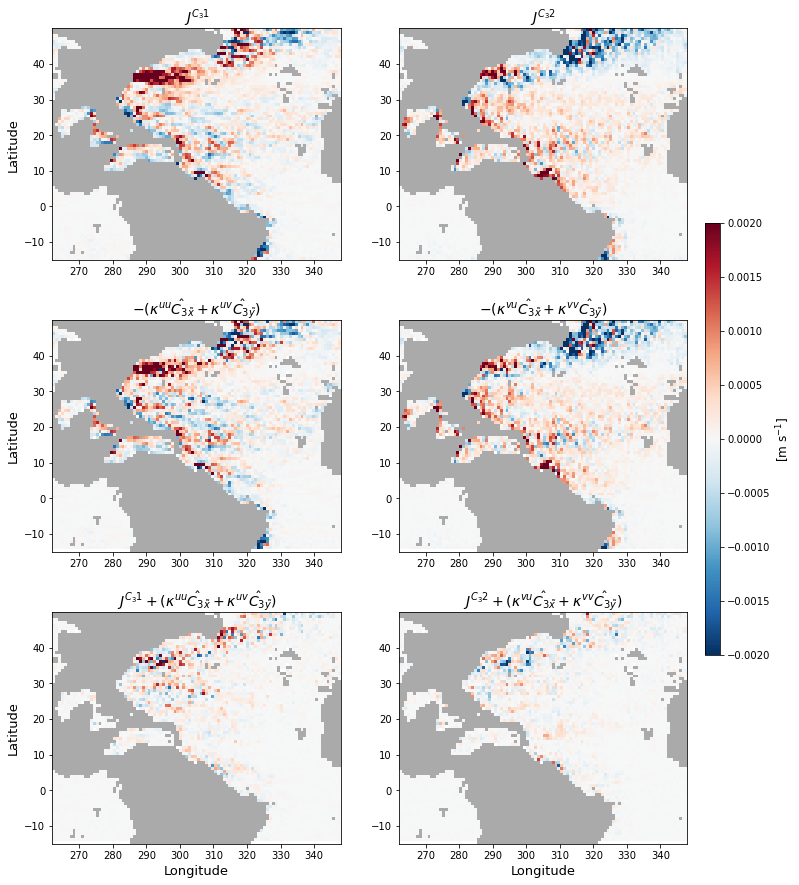

In [214]:
# maskK = np.ma.masked_invalid(K.isel(delta_outer=l)[:,:,0,0]).mask
maskK = np.ma.masked_values(np.ma.masked_invalid(K.isel(delta_outer=l)[:,:,0,0]),0.).mask
vlim = 2e-3
    
fig, axes = plt.subplots(figsize=(12,15), nrows=3, ncols=2)
        
# im0 = axes[0,0].contourf(K.XC, K.YC, uP3, 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im1 = axes[0,1].contourf(K.XC, K.YC, vP3, 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im2 = axes[1,0].contourf(K.XC, K.YC, 
#                            -(K.isel(delta_outer=l)[:,:,0,0] 
#                              * P3x_sm
#                              + K.isel(delta_outer=l)[:,:,1,0] 
#                              * P3y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im3 = axes[1,1].contourf(K.XC, K.YC, 
#                            -(K.isel(delta_outer=l)[:,:,0,1] 
#                              * P3x_sm
#                              + K.isel(delta_outer=l)[:,:,1,1] 
#                              * P3y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im4 = axes[2,0].contourf(K.XC, K.YC, 
#                          uP3 + (K.isel(delta_outer=l)[:,:,0,0] 
#                              * P3x_sm
#                              + K.isel(delta_outer=l)[:,:,1,0] 
#                              * P3y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im5 = axes[2,1].contourf(K.XC, K.YC, 
#                          vP3 + (K.isel(delta_outer=l)[:,:,0,1] 
#                              * P3x_sm
#                              + K.isel(delta_outer=l)[:,:,1,1] 
#                              * P3y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )

# for c in im0.collections:
#     c.set_rasterized(True)
# for c in im1.collections:
#     c.set_rasterized(True)
# for c in im2.collections:
#     c.set_rasterized(True)
# for c in im3.collections:
#     c.set_rasterized(True)
# for c in im4.collections:
#     c.set_rasterized(True)
# for c in im5.collections:
#     c.set_rasterized(True)

im0 = axes[0,0].pcolormesh(K.XC, K.YC, uP3, 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im1 = axes[0,1].pcolormesh(K.XC, K.YC, vP3, 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im2 = axes[1,0].pcolormesh(K.XC, K.YC, 
                           -(K.isel(delta_outer=l)[:,:,0,0] 
                             * P3x_sm
                             + K.isel(delta_outer=l)[:,:,1,0] 
                             * P3y_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im3 = axes[1,1].pcolormesh(K.XC, K.YC, 
                           -(K.isel(delta_outer=l)[:,:,0,1] 
                             * P3x_sm
                             + K.isel(delta_outer=l)[:,:,1,1] 
                             * P3y_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im4 = axes[2,0].pcolormesh(K.XC, K.YC, 
                         uP3 + (K.isel(delta_outer=l)[:,:,0,0] 
                             * P3x_sm
                             + K.isel(delta_outer=l)[:,:,1,0] 
                             * P3y_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im5 = axes[2,1].pcolormesh(K.XC, K.YC, 
                         vP3 + (K.isel(delta_outer=l)[:,:,0,1] 
                             * P3x_sm
                             + K.isel(delta_outer=l)[:,:,1,1] 
                             * P3y_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )


axes[0,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(K.XC, K.YC,
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,1].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)

axes[0,0].set_title(r"$J^{C_31}$", fontsize=14)
axes[0,1].set_title(r"$J^{C_32}$", fontsize=14)
axes[1,0].set_title(r"$-(\kappa^{uu}\hat{C_3}_\tilde{x} + \kappa^{uv} \hat{C_3}_\tilde{y})$", fontsize=14)
axes[1,1].set_title(r"$-(\kappa^{vu}\hat{C_3}_\tilde{x} + \kappa^{vv} \hat{C_3}_\tilde{y})$", fontsize=14)
axes[2,0].set_title(r"$J^{C_31}+(\kappa^{uu}\hat{C_3}_\tilde{x} + \kappa^{uv} \hat{C_3}_\tilde{y})$", fontsize=14)
axes[2,1].set_title(r"$J^{C_32}+(\kappa^{vu}\hat{C_3}_\tilde{x} + \kappa^{vv} \hat{C_3}_\tilde{y})$", fontsize=14)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.26) 
cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0, 
                         # ticks=[-30000,-20000,-10000,0,10000,20000,30000]
                    )
cbar0.set_label(r"[m s$^{-1}$]", fontsize=12)
# plt.savefig(op.join(spec,'figure/JC3-explicit_l=%2d_1967-01-01.pdf' % l))
plt.savefig(op.join(spec,'figure/JC3_l=%2d_1967-01-01.pdf' % l))

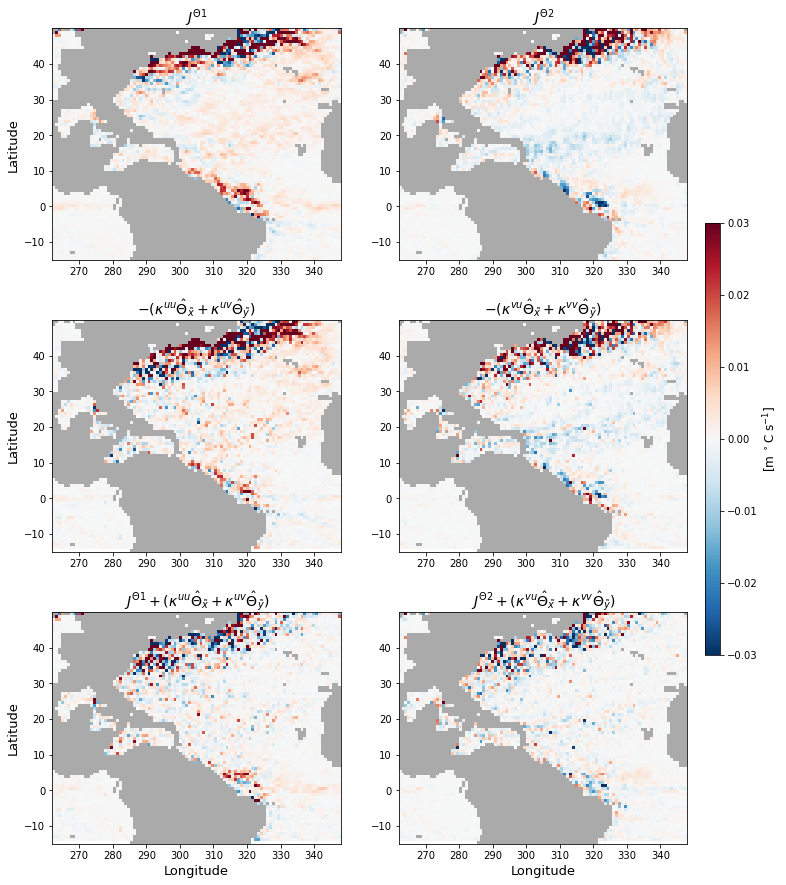

In [57]:
# maskK = np.ma.masked_invalid(K.isel(delta_outer=l)[:,:,0,0]).mask
maskK = np.ma.masked_values(np.ma.masked_invalid(K.isel(delta_outer=l)[:,:,0,0]),0.).mask
vlim = 3e-2
    
fig, axes = plt.subplots(figsize=(12,15), nrows=3, ncols=2)
        
# im0 = axes[0,0].contourf(K.XC, K.YC, uP3, 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im1 = axes[0,1].contourf(K.XC, K.YC, vP3, 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im2 = axes[1,0].contourf(K.XC, K.YC, 
#                            -(K.isel(delta_outer=l)[:,:,0,0] 
#                              * P3x_sm
#                              + K.isel(delta_outer=l)[:,:,1,0] 
#                              * P3y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im3 = axes[1,1].contourf(K.XC, K.YC, 
#                            -(K.isel(delta_outer=l)[:,:,0,1] 
#                              * P3x_sm
#                              + K.isel(delta_outer=l)[:,:,1,1] 
#                              * P3y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im4 = axes[2,0].contourf(K.XC, K.YC, 
#                          uP3 + (K.isel(delta_outer=l)[:,:,0,0] 
#                              * P3x_sm
#                              + K.isel(delta_outer=l)[:,:,1,0] 
#                              * P3y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im5 = axes[2,1].contourf(K.XC, K.YC, 
#                          vP3 + (K.isel(delta_outer=l)[:,:,0,1] 
#                              * P3x_sm
#                              + K.isel(delta_outer=l)[:,:,1,1] 
#                              * P3y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )

# for c in im0.collections:
#     c.set_rasterized(True)
# for c in im1.collections:
#     c.set_rasterized(True)
# for c in im2.collections:
#     c.set_rasterized(True)
# for c in im3.collections:
#     c.set_rasterized(True)
# for c in im4.collections:
#     c.set_rasterized(True)
# for c in im5.collections:
#     c.set_rasterized(True)

im0 = axes[0,0].pcolormesh(K.XC, K.YC, uT, 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im1 = axes[0,1].pcolormesh(K.XC, K.YC, vT, 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im2 = axes[1,0].pcolormesh(K.XC, K.YC, 
                           -(K.isel(delta_outer=l)[:,:,0,0] 
                             * Tx_sm
                             + K.isel(delta_outer=l)[:,:,1,0] 
                             * Ty_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im3 = axes[1,1].pcolormesh(K.XC, K.YC, 
                           -(K.isel(delta_outer=l)[:,:,0,1] 
                             * Tx_sm
                             + K.isel(delta_outer=l)[:,:,1,1] 
                             * Ty_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im4 = axes[2,0].pcolormesh(K.XC, K.YC, 
                         uT + (K.isel(delta_outer=l)[:,:,0,0] 
                             * Tx_sm
                             + K.isel(delta_outer=l)[:,:,1,0] 
                             * Ty_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im5 = axes[2,1].pcolormesh(K.XC, K.YC, 
                         vT + (K.isel(delta_outer=l)[:,:,0,1] 
                             * Tx_sm
                             + K.isel(delta_outer=l)[:,:,1,1] 
                             * Ty_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )


axes[0,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(K.XC, K.YC,
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,1].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)

axes[0,0].set_title(r"$J^{\Theta 1}$", fontsize=14)
axes[0,1].set_title(r"$J^{\Theta 2}$", fontsize=14)
axes[1,0].set_title(r"$-(\kappa^{uu}\hat{\Theta }_\tilde{x} + \kappa^{uv} \hat{\Theta }_\tilde{y})$", fontsize=14)
axes[1,1].set_title(r"$-(\kappa^{vu}\hat{\Theta }_\tilde{x} + \kappa^{vv} \hat{\Theta }_\tilde{y})$", fontsize=14)
axes[2,0].set_title(r"$J^{\Theta 1}+(\kappa^{uu}\hat{\Theta }_\tilde{x} + \kappa^{uv} \hat{\Theta }_\tilde{y})$", fontsize=14)
axes[2,1].set_title(r"$J^{\Theta 2}+(\kappa^{vu}\hat{\Theta }_\tilde{x} + \kappa^{vv} \hat{\Theta }_\tilde{y})$", fontsize=14)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.26) 
cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0, 
                         # ticks=[-30000,-20000,-10000,0,10000,20000,30000]
                    )
cbar0.set_label(r"[m $^\circ$C s$^{-1}$]", fontsize=12)
plt.savefig(op.join(spec,'figure/JT-explicit_l=%2d_1967-01-01.pdf' % l))
# plt.savefig(op.join(spec,'figure/JT_l=%2d_1967-01-01.pdf' % l))

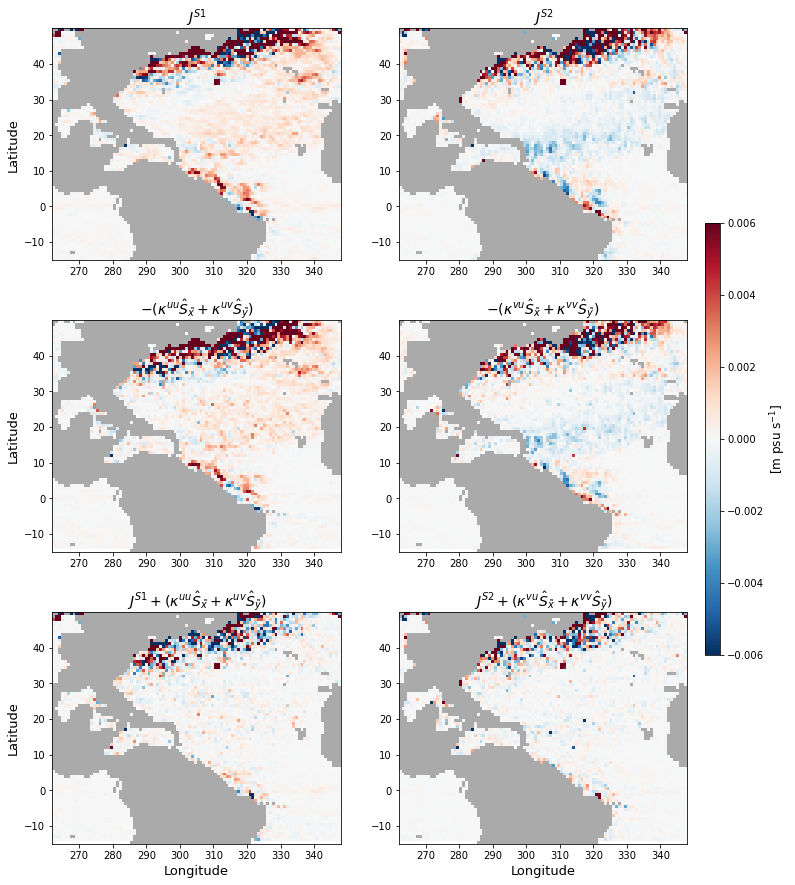

In [54]:
# maskK = np.ma.masked_invalid(K.isel(delta_outer=l)[:,:,0,0]).mask
maskK = np.ma.masked_values(np.ma.masked_invalid(K.isel(delta_outer=l)[:,:,0,0]),0.).mask
vlim = 6e-3
    
fig, axes = plt.subplots(figsize=(12,15), nrows=3, ncols=2)
        
# im0 = axes[0,0].contourf(K.XC, K.YC, uP3, 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im1 = axes[0,1].contourf(K.XC, K.YC, vP3, 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im2 = axes[1,0].contourf(K.XC, K.YC, 
#                            -(K.isel(delta_outer=l)[:,:,0,0] 
#                              * P3x_sm
#                              + K.isel(delta_outer=l)[:,:,1,0] 
#                              * P3y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im3 = axes[1,1].contourf(K.XC, K.YC, 
#                            -(K.isel(delta_outer=l)[:,:,0,1] 
#                              * P3x_sm
#                              + K.isel(delta_outer=l)[:,:,1,1] 
#                              * P3y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im4 = axes[2,0].contourf(K.XC, K.YC, 
#                          uP3 + (K.isel(delta_outer=l)[:,:,0,0] 
#                              * P3x_sm
#                              + K.isel(delta_outer=l)[:,:,1,0] 
#                              * P3y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )
# im5 = axes[2,1].contourf(K.XC, K.YC, 
#                          vP3 + (K.isel(delta_outer=l)[:,:,0,1] 
#                              * P3x_sm
#                              + K.isel(delta_outer=l)[:,:,1,1] 
#                              * P3y_sm
#                             ), 
#                            cmap='RdBu_r', 
#                          # levels = np.linspace(-1e-2,1e-2,21), 
#                          levels = np.linspace(-2e-3,2e-3,21), 
#                          extend='both'
#                            # vmin=-1e-2, vmax=1e-2, rasterized=True,
#                           )

# for c in im0.collections:
#     c.set_rasterized(True)
# for c in im1.collections:
#     c.set_rasterized(True)
# for c in im2.collections:
#     c.set_rasterized(True)
# for c in im3.collections:
#     c.set_rasterized(True)
# for c in im4.collections:
#     c.set_rasterized(True)
# for c in im5.collections:
#     c.set_rasterized(True)

im0 = axes[0,0].pcolormesh(K.XC, K.YC, uS, 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im1 = axes[0,1].pcolormesh(K.XC, K.YC, vS, 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im2 = axes[1,0].pcolormesh(K.XC, K.YC, 
                           -(K.isel(delta_outer=l)[:,:,0,0] 
                             * Sx_sm
                             + K.isel(delta_outer=l)[:,:,1,0] 
                             * Sy_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im3 = axes[1,1].pcolormesh(K.XC, K.YC, 
                           -(K.isel(delta_outer=l)[:,:,0,1] 
                             * Sx_sm
                             + K.isel(delta_outer=l)[:,:,1,1] 
                             * Sy_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im4 = axes[2,0].pcolormesh(K.XC, K.YC, 
                         uS + (K.isel(delta_outer=l)[:,:,0,0] 
                             * Sx_sm
                             + K.isel(delta_outer=l)[:,:,1,0] 
                             * Sy_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )
im5 = axes[2,1].pcolormesh(K.XC, K.YC, 
                         vS + (K.isel(delta_outer=l)[:,:,0,1] 
                             * Sx_sm
                             + K.isel(delta_outer=l)[:,:,1,1] 
                             * Sy_sm
                            ), 
                           cmap='RdBu_r', 
                         # # levels = np.linspace(-1e-2,1e-2,21), 
                         # levels = np.linspace(-2e-3,2e-3,21), 
                         # extend='both'
                           vmin=-vlim, vmax=vlim, rasterized=True,
                          )


axes[0,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(K.XC, K.YC,
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,0].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC),
                     vmin=0, vmax=3, cmap='binary', rasterized=True)
axes[2,1].pcolormesh(K.XC, K.YC, 
                     np.ma.masked_array(maskC, ~maskC), 
                     vmin=0, vmax=3, cmap='binary', rasterized=True)

axes[0,0].set_title(r"$J^{S 1}$", fontsize=14)
axes[0,1].set_title(r"$J^{S 2}$", fontsize=14)
axes[1,0].set_title(r"$-(\kappa^{uu}\hat{S }_\tilde{x} + \kappa^{uv} \hat{S }_\tilde{y})$", fontsize=14)
axes[1,1].set_title(r"$-(\kappa^{vu}\hat{S }_\tilde{x} + \kappa^{vv} \hat{S }_\tilde{y})$", fontsize=14)
axes[2,0].set_title(r"$J^{S 1}+(\kappa^{uu}\hat{S }_\tilde{x} + \kappa^{uv} \hat{S }_\tilde{y})$", fontsize=14)
axes[2,1].set_title(r"$J^{S 2}+(\kappa^{vu}\hat{S }_\tilde{x} + \kappa^{vv} \hat{S }_\tilde{y})$", fontsize=14)

axes[2,0].set_xlabel(r"Longitude", fontsize=13)
axes[2,1].set_xlabel(r"Longitude", fontsize=13)
axes[0,0].set_ylabel(r"Latitude", fontsize=13)
axes[1,0].set_ylabel(r"Latitude", fontsize=13)
axes[2,0].set_ylabel(r"Latitude", fontsize=13)

fig.subplots_adjust(right=0.86, hspace=.26) 
cbax0 = fig.add_axes([0.88, 0.3, 0.018, 0.4])
cbar0 = fig.colorbar(im0, orientation='vertical', cax=cbax0, 
                         # ticks=[-30000,-20000,-10000,0,10000,20000,30000]
                    )
cbar0.set_label(r"[m psu s$^{-1}$]", fontsize=12)
plt.savefig(op.join(spec,'figure/JS-explicit_l=%2d_1967-01-01.pdf' % l))
# plt.savefig(op.join(spec,'figure/JS_l=%2d_1967-01-01.pdf' % l))

In [83]:
xc = 300

uP0 = ((upP0hat_sm * ds.rA.where(wet_mask!=0.)
       )
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False)
       / rAc).sel(XC=xc, method='nearest').compute()
vP0 = ((vpP0hat_sm * ds.rA.where(wet_mask!=0.)
       )
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc).sel(XC=xc, method='nearest').compute()
uP1 = ((upP1hat_sm * ds.rA.where(wet_mask!=0.)
       )
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc).sel(XC=xc, method='nearest').compute()
vP1 = ((vpP1hat_sm * ds.rA.where(wet_mask!=0.)
       )
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc).sel(XC=xc, method='nearest').compute()
uP2 = ((upP2hat_sm * ds.rA.where(wet_mask!=0.)
       )
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc).sel(XC=xc, method='nearest').compute()
vP2 = ((vpP2hat_sm * ds.rA.where(wet_mask!=0.)
       )
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc).sel(XC=xc, method='nearest').compute()
uP3 = ((upP3hat_sm * ds.rA.where(wet_mask!=0.)
       )
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc).sel(XC=xc, method='nearest').compute()
vP3 = ((vpP3hat_sm * ds.rA.where(wet_mask!=0.)
       )
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc).sel(XC=xc, method='nearest').compute()

P0x_sm = ((P0bsm_x * ds.rA.where(wet_mask!=0.)
       )
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc).sel(XC=xc, method='nearest').compute()
P0y_sm = ((P0bsm_y * ds.rA.where(wet_mask!=0.)
       )
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc).sel(XC=xc, method='nearest').compute()
P1x_sm = ((P1bsm_x * ds.rA.where(wet_mask!=0.)
       )
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc).sel(XC=xc, method='nearest').compute()
P1y_sm = ((P1bsm_y * ds.rA.where(wet_mask!=0.)
       )
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc).sel(XC=xc, method='nearest').compute()
P2x_sm = ((P2bsm_x * ds.rA.where(wet_mask!=0.)
       )
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc).sel(XC=xc, method='nearest').compute()
P2y_sm = ((P2bsm_y * ds.rA.where(wet_mask!=0.)
       )
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc).sel(XC=xc, method='nearest').compute()
P3x_sm = ((P3bsm_x * ds.rA.where(wet_mask!=0.)
       )
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc).sel(XC=xc, method='nearest').compute()
P3y_sm = ((P3bsm_y * ds.rA.where(wet_mask!=0.)
       )
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc).sel(XC=xc, method='nearest').compute()

In [92]:
xc = 300

uT = ((upThat_sm * ds.rA.where(wet_mask!=0.)
       )
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False)
       / rAc).sel(XC=xc, method='nearest').compute()
vT = ((vpThat_sm * ds.rA.where(wet_mask!=0.)
       )
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc).sel(XC=xc, method='nearest').compute()
uS = ((upShat_sm * ds.rA.where(wet_mask!=0.)
       )
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc).sel(XC=xc, method='nearest').compute()
vS = ((vpShat_sm * ds.rA.where(wet_mask!=0.)
       )
       .isel(YC=slice(1,-1))
       .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
       / rAc).sel(XC=xc, method='nearest').compute()

Tx_sm = ((thatsm_x * ds.rA.where(wet_mask!=0.)
       )
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc).sel(XC=xc, method='nearest').compute()
Ty_sm = ((thatsm_y * ds.rA.where(wet_mask!=0.)
       )
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc).sel(XC=xc, method='nearest').compute()
Sx_sm = ((shatsm_x * ds.rA.where(wet_mask!=0.)
       )
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc).sel(XC=xc, method='nearest').compute()
Sy_sm = ((shatsm_y * ds.rA.where(wet_mask!=0.)
       )
          .isel(YC=slice(1,-1))
          .coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=False) 
          / rAc).sel(XC=xc, method='nearest').compute()

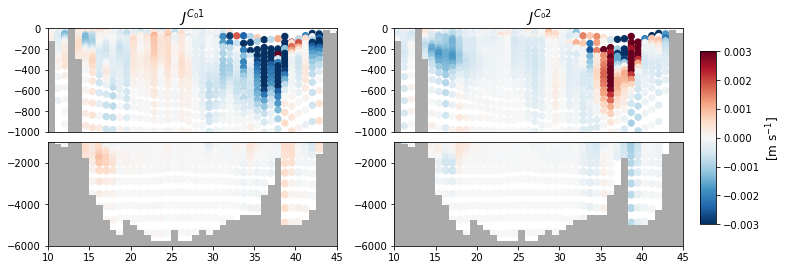

In [70]:
fig, axes = plt.subplots(figsize=(12,4), nrows=2, ncols=2)

im = axes[0,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=uP0.data.T,
           s=40, 
           cmap='RdBu_r', 
           vmin=-3e-3, vmax=3e-3
          )
axes[1,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=uP0.data.T,
           s=50, 
           cmap='RdBu_r', 
           vmin=-3e-3, vmax=3e-3
          )

axes[0,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=vP0.data.T,
           s=40, 
           cmap='RdBu_r', 
           vmin=-3e-3, vmax=3e-3
          )
axes[1,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=vP0.data.T,
           s=50, 
           cmap='RdBu_r', 
           vmin=-3e-3, vmax=3e-3
          )

axes[0,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)

axes[0,0].set_ylim([-1000,0])
axes[0,0].set_xlim([10,45])
axes[0,0].set_xticks([])
axes[1,0].set_ylim([None,-1000])
axes[1,0].set_xlim([10,45])
axes[0,1].set_ylim([-1000,0])
axes[0,1].set_xlim([10,45])
axes[0,1].set_xticks([])
axes[1,1].set_ylim([None,-1000])
axes[1,1].set_xlim([10,45])

axes[0,0].set_title(r"$J^{C_0 1}$", fontsize=14)
axes[0,1].set_title(r"$J^{C_0 2}$", fontsize=14)

fig.subplots_adjust(right=0.86, hspace=.1) 
cbax0 = fig.add_axes([0.88, 0.2, 0.018, 0.6])
cbar0 = fig.colorbar(im, orientation='vertical', cax=cbax0,
                     # ticks=[-7e4,-1e4,-1e3,-1e2,1e2,1e3,1e4,7e4]
                     # ticks=[-1e5,-75e3,-50000,-25000,0,25000,50000,75000,100000]
                    )
cbar0.set_label(r"[m s$^{-1}$]", fontsize=12)

plt.savefig(op.join(spec,'figure/upP0p_XC=%3d_1967-01-01.pdf' % xc))

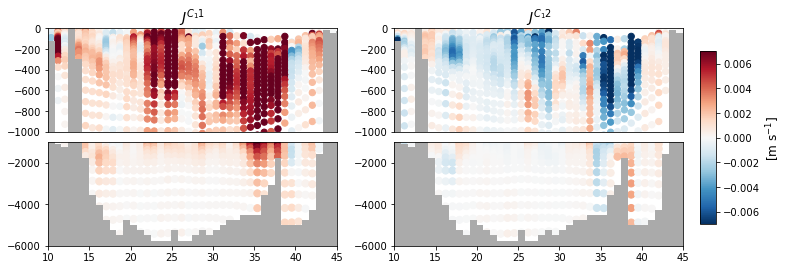

In [85]:
fig, axes = plt.subplots(figsize=(12,4), nrows=2, ncols=2)

im = axes[0,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=uP1.data.T,
           s=40, 
           cmap='RdBu_r', 
           vmin=-7e-3, vmax=7e-3
          )
axes[1,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=uP1.data.T,
           s=50, 
           cmap='RdBu_r', 
           vmin=-7e-3, vmax=7e-3
          )

axes[0,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=vP1.data.T,
           s=40, 
           cmap='RdBu_r', 
           vmin=-7e-3, vmax=7e-3
          )
axes[1,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=vP1.data.T,
           s=50, 
           cmap='RdBu_r', 
           vmin=-7e-3, vmax=7e-3
          )

axes[0,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)

axes[0,0].set_ylim([-1000,0])
axes[0,0].set_xlim([10,45])
axes[0,0].set_xticks([])
axes[1,0].set_ylim([None,-1000])
axes[1,0].set_xlim([10,45])
axes[0,1].set_ylim([-1000,0])
axes[0,1].set_xlim([10,45])
axes[0,1].set_xticks([])
axes[1,1].set_ylim([None,-1000])
axes[1,1].set_xlim([10,45])

axes[0,0].set_title(r"$J^{C_1 1}$", fontsize=14)
axes[0,1].set_title(r"$J^{C_1 2}$", fontsize=14)

fig.subplots_adjust(right=0.86, hspace=.1) 
cbax0 = fig.add_axes([0.88, 0.2, 0.018, 0.6])
cbar0 = fig.colorbar(im, orientation='vertical', cax=cbax0,
                     # ticks=[-7e4,-1e4,-1e3,-1e2,1e2,1e3,1e4,7e4]
                     # ticks=[-1e5,-75e3,-50000,-25000,0,25000,50000,75000,100000]
                    )
cbar0.set_label(r"[m s$^{-1}$]", fontsize=12)

plt.savefig(op.join(spec,'figure/upP1p_XC=%3d_1967-01-01.pdf' % xc))

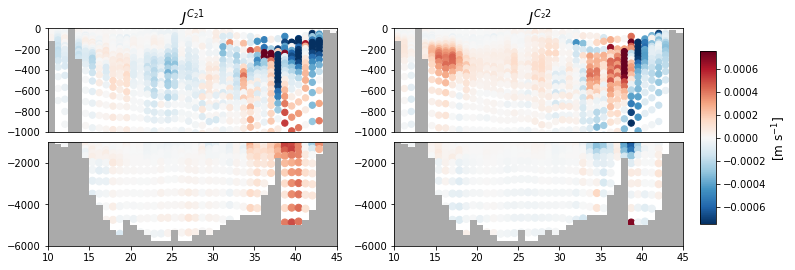

In [86]:
fig, axes = plt.subplots(figsize=(12,4), nrows=2, ncols=2)

im = axes[0,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=uP2.data.T,
           s=40, 
           cmap='RdBu_r', 
           vmin=-.75e-3, vmax=.75e-3
          )
axes[1,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=uP2.data.T,
           s=50, 
           cmap='RdBu_r', 
           vmin=-.75e-3, vmax=.75e-3
          )

axes[0,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=vP2.data.T,
           s=40, 
           cmap='RdBu_r', 
           vmin=-.75e-3, vmax=.75e-3
          )
axes[1,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=vP2.data.T,
           s=50, 
           cmap='RdBu_r', 
           vmin=-.75e-3, vmax=.75e-3
          )

axes[0,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)

axes[0,0].set_ylim([-1000,0])
axes[0,0].set_xlim([10,45])
axes[0,0].set_xticks([])
axes[1,0].set_ylim([None,-1000])
axes[1,0].set_xlim([10,45])
axes[0,1].set_ylim([-1000,0])
axes[0,1].set_xlim([10,45])
axes[0,1].set_xticks([])
axes[1,1].set_ylim([None,-1000])
axes[1,1].set_xlim([10,45])

axes[0,0].set_title(r"$J^{C_2 1}$", fontsize=14)
axes[0,1].set_title(r"$J^{C_2 2}$", fontsize=14)

fig.subplots_adjust(right=0.86, hspace=.1) 
cbax0 = fig.add_axes([0.88, 0.2, 0.018, 0.6])
cbar0 = fig.colorbar(im, orientation='vertical', cax=cbax0,
                     # ticks=[-7e4,-1e4,-1e3,-1e2,1e2,1e3,1e4,7e4]
                     # ticks=[-1e5,-75e3,-50000,-25000,0,25000,50000,75000,100000]
                    )
cbar0.set_label(r"[m s$^{-1}$]", fontsize=12)

plt.savefig(op.join(spec,'figure/upP2p_XC=%3d_1967-01-01.pdf' % xc))

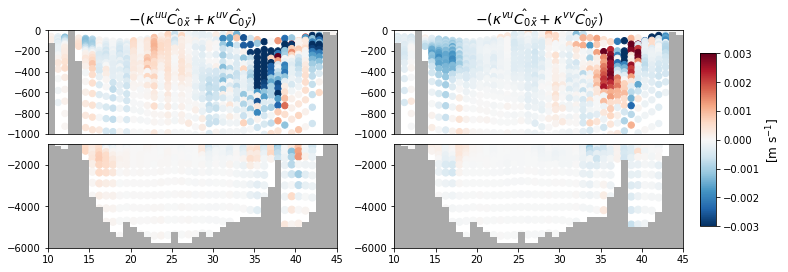

In [71]:
fig, axes = plt.subplots(figsize=(12,4), nrows=2, ncols=2)

im = axes[0,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,0] 
                * P0x_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,0] 
                * P0y_sm
               )).data,
           s=40, 
           cmap='RdBu_r', 
           vmin=-3e-3, vmax=3e-3
          )
axes[1,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,0] 
                * P0x_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,0] 
                * P0y_sm
               )).data,
           s=50, 
           cmap='RdBu_r', 
           vmin=-3e-3, vmax=3e-3
          )

axes[0,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,1] 
                * P0x_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,1] 
                * P0y_sm
               )).data,
           s=40, 
           cmap='RdBu_r', 
           vmin=-3e-3, vmax=3e-3
          )
axes[1,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,1] 
                * P0x_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,1] 
                * P0y_sm
               )).data,
           s=50, 
           cmap='RdBu_r', 
           vmin=-3e-3, vmax=3e-3
          )

axes[0,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)

axes[0,0].set_ylim([-1000,0])
axes[0,0].set_xlim([10,45])
axes[0,0].set_xticks([])
axes[1,0].set_ylim([None,-1000])
axes[1,0].set_xlim([10,45])
axes[0,1].set_ylim([-1000,0])
axes[0,1].set_xlim([10,45])
axes[0,1].set_xticks([])
axes[1,1].set_ylim([None,-1000])
axes[1,1].set_xlim([10,45])

axes[0,0].set_title(r"$-(\kappa^{uu}\hat{C_0 }_\tilde{x} + \kappa^{uv} \hat{C_0 }_\tilde{y})$", fontsize=14)
axes[0,1].set_title(r"$-(\kappa^{vu}\hat{C_0 }_\tilde{x} + \kappa^{vv} \hat{C_0 }_\tilde{y})$", fontsize=14)

fig.subplots_adjust(right=0.86, hspace=.1) 
cbax0 = fig.add_axes([0.88, 0.2, 0.018, 0.6])
cbar0 = fig.colorbar(im, orientation='vertical', cax=cbax0,
                     # ticks=[-7e4,-1e4,-1e3,-1e2,1e2,1e3,1e4,7e4]
                     # ticks=[-1e5,-75e3,-50000,-25000,0,25000,50000,75000,100000]
                    )
cbar0.set_label(r"[m s$^{-1}$]", fontsize=12)

plt.savefig(op.join(spec,'figure/P0p-recont_XC=%3d_1967-01-01.pdf' % xc))

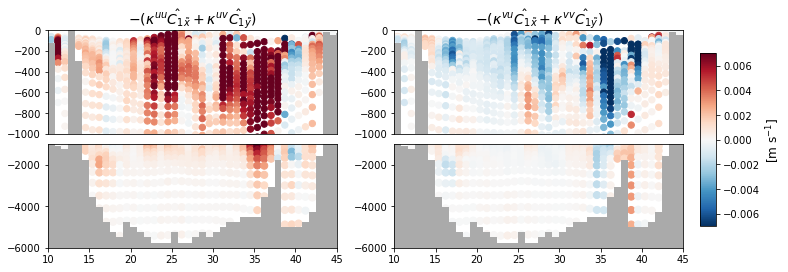

In [69]:
fig, axes = plt.subplots(figsize=(12,4), nrows=2, ncols=2)

im = axes[0,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,0] 
                * P1x_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,0] 
                * P1y_sm
               )).data,
           s=40, 
           cmap='RdBu_r', 
           vmin=-7e-3, vmax=7e-3
          )
axes[1,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,0] 
                * P1x_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,0] 
                * P1y_sm
               )).data,
           s=50, 
           cmap='RdBu_r', 
           vmin=-7e-3, vmax=7e-3
          )

axes[0,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,1] 
                * P1x_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,1] 
                * P1y_sm
               )).data,
           s=40, 
           cmap='RdBu_r', 
           vmin=-7e-3, vmax=7e-3
          )
axes[1,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,1] 
                * P1x_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,1] 
                * P1y_sm
               )).data,
           s=50, 
           cmap='RdBu_r', 
           vmin=-7e-3, vmax=7e-3
          )

axes[0,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)

axes[0,0].set_ylim([-1000,0])
axes[0,0].set_xlim([10,45])
axes[0,0].set_xticks([])
axes[1,0].set_ylim([None,-1000])
axes[1,0].set_xlim([10,45])
axes[0,1].set_ylim([-1000,0])
axes[0,1].set_xlim([10,45])
axes[0,1].set_xticks([])
axes[1,1].set_ylim([None,-1000])
axes[1,1].set_xlim([10,45])

axes[0,0].set_title(r"$-(\kappa^{uu}\hat{C_1 }_\tilde{x} + \kappa^{uv} \hat{C_1 }_\tilde{y})$", fontsize=14)
axes[0,1].set_title(r"$-(\kappa^{vu}\hat{C_1 }_\tilde{x} + \kappa^{vv} \hat{C_1 }_\tilde{y})$", fontsize=14)

fig.subplots_adjust(right=0.86, hspace=.1) 
cbax0 = fig.add_axes([0.88, 0.2, 0.018, 0.6])
cbar0 = fig.colorbar(im, orientation='vertical', cax=cbax0,
                     # ticks=[-7e4,-1e4,-1e3,-1e2,1e2,1e3,1e4,7e4]
                     # ticks=[-1e5,-75e3,-50000,-25000,0,25000,50000,75000,100000]
                    )
cbar0.set_label(r"[m s$^{-1}$]", fontsize=12)

plt.savefig(op.join(spec,'figure/P1p-recont_XC=%3d_1967-01-01.pdf' % xc))

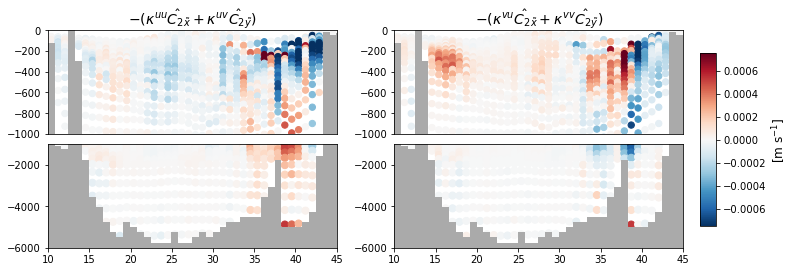

In [73]:
fig, axes = plt.subplots(figsize=(12,4), nrows=2, ncols=2)

im = axes[0,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,0] 
                * P2x_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,0] 
                * P2y_sm
               )).data,
           s=40, 
           cmap='RdBu_r', 
           vmin=-.75e-3, vmax=.75e-3
          )
axes[1,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,0] 
                * P2x_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,0] 
                * P2y_sm
               )).data,
           s=50, 
           cmap='RdBu_r', 
           vmin=-.75e-3, vmax=.75e-3
          )

axes[0,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,1] 
                * P2x_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,1] 
                * P2y_sm
               )).data,
           s=40, 
           cmap='RdBu_r', 
           vmin=-.75e-3, vmax=.75e-3
          )
axes[1,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,1] 
                * P2x_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,1] 
                * P2y_sm
               )).data,
           s=50, 
           cmap='RdBu_r', 
           vmin=-.75e-3, vmax=.75e-3
          )

axes[0,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)

axes[0,0].set_ylim([-1000,0])
axes[0,0].set_xlim([10,45])
axes[0,0].set_xticks([])
axes[1,0].set_ylim([None,-1000])
axes[1,0].set_xlim([10,45])
axes[0,1].set_ylim([-1000,0])
axes[0,1].set_xlim([10,45])
axes[0,1].set_xticks([])
axes[1,1].set_ylim([None,-1000])
axes[1,1].set_xlim([10,45])

axes[0,0].set_title(r"$-(\kappa^{uu}\hat{C_2 }_\tilde{x} + \kappa^{uv} \hat{C_2 }_\tilde{y})$", fontsize=14)
axes[0,1].set_title(r"$-(\kappa^{vu}\hat{C_2 }_\tilde{x} + \kappa^{vv} \hat{C_2 }_\tilde{y})$", fontsize=14)

fig.subplots_adjust(right=0.86, hspace=.1) 
cbax0 = fig.add_axes([0.88, 0.2, 0.018, 0.6])
cbar0 = fig.colorbar(im, orientation='vertical', cax=cbax0,
                     # ticks=[-7e4,-1e4,-1e3,-1e2,1e2,1e3,1e4,7e4]
                     # ticks=[-1e5,-75e3,-50000,-25000,0,25000,50000,75000,100000]
                    )
cbar0.set_label(r"[m s$^{-1}$]", fontsize=12)

plt.savefig(op.join(spec,'figure/P2p-recont_XC=%3d_1967-01-01.pdf' % xc))

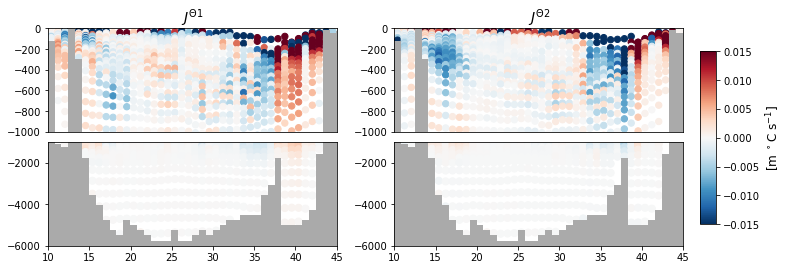

In [87]:
fig, axes = plt.subplots(figsize=(12,4), nrows=2, ncols=2)

im = axes[0,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=uT.data.T,
           s=40, 
           cmap='RdBu_r', 
           vmin=-1.5e-2, vmax=1.5e-2
          )
axes[1,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=uT.data.T,
           s=50, 
           cmap='RdBu_r', 
           vmin=-1.5e-2, vmax=1.5e-2
          )

axes[0,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=vT.data.T,
           s=40, 
           cmap='RdBu_r', 
           vmin=-1.5e-2, vmax=1.5e-2
          )
axes[1,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=vT.data.T,
           s=50, 
           cmap='RdBu_r', 
           vmin=-1.5e-2, vmax=1.5e-2
          )

axes[0,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)

axes[0,0].set_ylim([-1000,0])
axes[0,0].set_xlim([10,45])
axes[0,0].set_xticks([])
axes[1,0].set_ylim([None,-1000])
axes[1,0].set_xlim([10,45])
axes[0,1].set_ylim([-1000,0])
axes[0,1].set_xlim([10,45])
axes[0,1].set_xticks([])
axes[1,1].set_ylim([None,-1000])
axes[1,1].set_xlim([10,45])

axes[0,0].set_title(r"$J^{\Theta 1}$", fontsize=14)
axes[0,1].set_title(r"$J^{\Theta 2}$", fontsize=14)

fig.subplots_adjust(right=0.86, hspace=.1) 
cbax0 = fig.add_axes([0.88, 0.2, 0.018, 0.6])
cbar0 = fig.colorbar(im, orientation='vertical', cax=cbax0,
                     # ticks=[-7e4,-1e4,-1e3,-1e2,1e2,1e3,1e4,7e4]
                     # ticks=[-1e5,-75e3,-50000,-25000,0,25000,50000,75000,100000]
                    )
cbar0.set_label(r"[m $^\circ$C s$^{-1}$]", fontsize=12)

plt.savefig(op.join(spec,'figure/upTp_XC=%3d_1967-01-01.pdf' % xc))

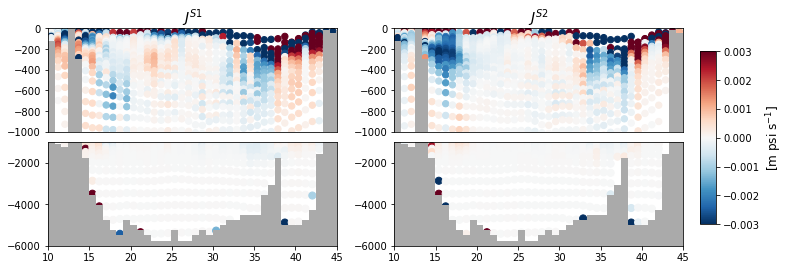

In [88]:
fig, axes = plt.subplots(figsize=(12,4), nrows=2, ncols=2)

im = axes[0,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=uS.data.T,
           s=40, 
           cmap='RdBu_r', 
           vmin=-3e-3, vmax=3e-3
          )
axes[1,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=uS.data.T,
           s=50, 
           cmap='RdBu_r', 
           vmin=-3e-3, vmax=3e-3
          )

axes[0,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=vS.data.T,
           s=40, 
           cmap='RdBu_r', 
           vmin=-3e-3, vmax=3e-3
          )
axes[1,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=vS.data.T,
           s=50, 
           cmap='RdBu_r', 
           vmin=-3e-3, vmax=3e-3
          )

axes[0,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)

axes[0,0].set_ylim([-1000,0])
axes[0,0].set_xlim([10,45])
axes[0,0].set_xticks([])
axes[1,0].set_ylim([None,-1000])
axes[1,0].set_xlim([10,45])
axes[0,1].set_ylim([-1000,0])
axes[0,1].set_xlim([10,45])
axes[0,1].set_xticks([])
axes[1,1].set_ylim([None,-1000])
axes[1,1].set_xlim([10,45])

axes[0,0].set_title(r"$J^{S 1}$", fontsize=14)
axes[0,1].set_title(r"$J^{S 2}$", fontsize=14)

fig.subplots_adjust(right=0.86, hspace=.1) 
cbax0 = fig.add_axes([0.88, 0.2, 0.018, 0.6])
cbar0 = fig.colorbar(im, orientation='vertical', cax=cbax0,
                     # ticks=[-7e4,-1e4,-1e3,-1e2,1e2,1e3,1e4,7e4]
                     # ticks=[-1e5,-75e3,-50000,-25000,0,25000,50000,75000,100000]
                    )
cbar0.set_label(r"[m psi s$^{-1}$]", fontsize=12)

plt.savefig(op.join(spec,'figure/upSp_XC=%3d_1967-01-01.pdf' % xc))

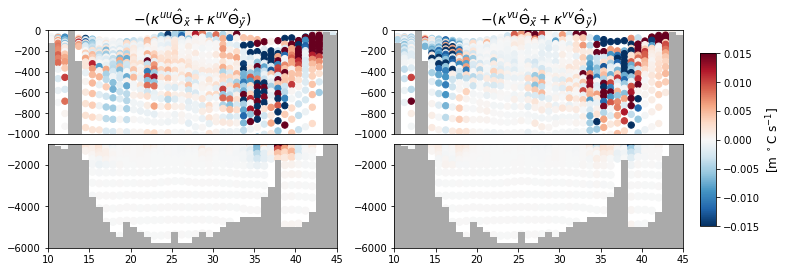

In [76]:
fig, axes = plt.subplots(figsize=(12,4), nrows=2, ncols=2)

im = axes[0,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,0] 
                * Tx_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,0] 
                * Ty_sm
               )).data,
           s=40, 
           cmap='RdBu_r', 
           vmin=-1.5e-2, vmax=1.5e-2
          )
axes[1,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,0] 
                * Tx_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,0] 
                * Ty_sm
               )).data,
           s=50, 
           cmap='RdBu_r', 
           vmin=-1.5e-2, vmax=1.5e-2
          )

axes[0,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,1] 
                * Tx_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,1] 
                * Ty_sm
               )).data,
           s=40, 
           cmap='RdBu_r', 
           vmin=-1.5e-2, vmax=1.5e-2
          )
axes[1,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,1] 
                * Tx_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,1] 
                * Ty_sm
               )).data,
           s=50, 
           cmap='RdBu_r', 
           vmin=-1.5e-2, vmax=1.5e-2
          )

axes[0,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)

axes[0,0].set_ylim([-1000,0])
axes[0,0].set_xlim([10,45])
axes[0,0].set_xticks([])
axes[1,0].set_ylim([None,-1000])
axes[1,0].set_xlim([10,45])
axes[0,1].set_ylim([-1000,0])
axes[0,1].set_xlim([10,45])
axes[0,1].set_xticks([])
axes[1,1].set_ylim([None,-1000])
axes[1,1].set_xlim([10,45])

axes[0,0].set_title(r"$-(\kappa^{uu}\hat{\Theta }_\tilde{x} + \kappa^{uv} \hat{\Theta }_\tilde{y})$", fontsize=14)
axes[0,1].set_title(r"$-(\kappa^{vu}\hat{\Theta }_\tilde{x} + \kappa^{vv} \hat{\Theta }_\tilde{y})$", fontsize=14)

fig.subplots_adjust(right=0.86, hspace=.1) 
cbax0 = fig.add_axes([0.88, 0.2, 0.018, 0.6])
cbar0 = fig.colorbar(im, orientation='vertical', cax=cbax0,
                     # ticks=[-7e4,-1e4,-1e3,-1e2,1e2,1e3,1e4,7e4]
                     # ticks=[-1e5,-75e3,-50000,-25000,0,25000,50000,75000,100000]
                    )
cbar0.set_label(r"[m $^\circ$C s$^{-1}$]", fontsize=12)

plt.savefig(op.join(spec,'figure/Tp-recont_XC=%3d_1967-01-01.pdf' % xc))

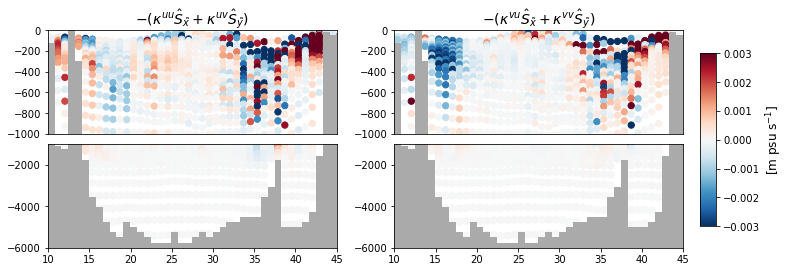

In [93]:
fig, axes = plt.subplots(figsize=(12,4), nrows=2, ncols=2)

im = axes[0,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,0] 
                * Sx_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,0] 
                * Sy_sm
               )).data,
           s=40, 
           cmap='RdBu_r', 
           vmin=-3e-3, vmax=3e-3
          )
axes[1,0].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,0] 
                * Sx_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,0] 
                * Sy_sm
               )).data,
           s=50, 
           cmap='RdBu_r', 
           vmin=-3e-3, vmax=3e-3
          )

axes[0,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,1] 
                * Sx_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,1] 
                * Sy_sm
               )).data,
           s=40, 
           cmap='RdBu_r', 
           vmin=-3e-3, vmax=3e-3
          )
axes[1,1].scatter(K.YC.data[:,np.newaxis]*np.ones(len(zetab.delta_outer)), zetabC.sel(XC=xc, method='nearest').data, 
           c=(-(K.sel(XC=xc, method='nearest')[:,:,0,1] 
                * Sx_sm
                + K.sel(XC=xc, method='nearest')[:,:,1,1] 
                * Sy_sm
               )).data,
           s=50, 
           cmap='RdBu_r', 
           vmin=-3e-3, vmax=3e-3
          )

axes[0,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,0].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[0,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)
axes[1,1].pcolormesh(maskCC.YC, maskCC.Z, 
               maskCC.sel(XC=xc, method='nearest'),
               vmin=-1, vmax=2, cmap='binary', rasterized=True)

axes[0,0].set_ylim([-1000,0])
axes[0,0].set_xlim([10,45])
axes[0,0].set_xticks([])
axes[1,0].set_ylim([None,-1000])
axes[1,0].set_xlim([10,45])
axes[0,1].set_ylim([-1000,0])
axes[0,1].set_xlim([10,45])
axes[0,1].set_xticks([])
axes[1,1].set_ylim([None,-1000])
axes[1,1].set_xlim([10,45])

axes[0,0].set_title(r"$-(\kappa^{uu}\hat{S }_\tilde{x} + \kappa^{uv} \hat{S }_\tilde{y})$", fontsize=14)
axes[0,1].set_title(r"$-(\kappa^{vu}\hat{S }_\tilde{x} + \kappa^{vv} \hat{S }_\tilde{y})$", fontsize=14)

fig.subplots_adjust(right=0.86, hspace=.1) 
cbax0 = fig.add_axes([0.88, 0.2, 0.018, 0.6])
cbar0 = fig.colorbar(im, orientation='vertical', cax=cbax0,
                     # ticks=[-7e4,-1e4,-1e3,-1e2,1e2,1e3,1e4,7e4]
                     # ticks=[-1e5,-75e3,-50000,-25000,0,25000,50000,75000,100000]
                    )
cbar0.set_label(r"[m psu s$^{-1}$]", fontsize=12)

plt.savefig(op.join(spec,'figure/Sp-recont_XC=%3d_1967-01-01.pdf' % xc))